# V2
## Changements :
- réduction perception passager
- xp avec multi processing


### UNITES
1 TICK = 1 SECONDE

In [2]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import shapely
import random
import numpy as np
from IPython.display import clear_output
import math
from mas_transportation_utils import *
#from mas_transportation_utils import all_paths
import rtree

%matplotlib inline
ox.config(log_console=True)
ox.__version__
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

ox.utils.config(bidirectional_network_types=['drive'])

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

In [3]:
class Agent:
    def __init__(self, unique_id):
        self.is_alive = True
        self.unique_id = unique_id
    
    def update(self) -> None: 
        pass
    
    def decide(self) -> None:
        pass
    
class UserAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr):
        super().__init__(unique_id)
        self.v_dep = v_dep
        self.v_r = v_dep
        self.v_arr = v_arr
        
        #calcul de la longueur du plus court chemin à l'origine
        ###self.SPL = nx.shortest_path_length(sma.G, source=self.v_dep, target=self.v_arr)
        
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass    

In [4]:
class ContinuousDriverAgent(UserAgent):
    '''pref might be : "length" or "travel_time"'''
    def __init__(self, unique_id, v_dep, v_arr, capacity=3, detour_factor=0, pref_weight='travel_time', test=False):
        super().__init__(unique_id, v_dep, v_arr)
        
        self.dep_time = sma.tick
        
        self.pref_weight = pref_weight
        self.detour_factor = detour_factor
        self.SP = ox.shortest_path(sma.G, self.v_dep, self.v_arr, weight=pref_weight)
        self.SPt = compute_shortest_path_time(sma.G, self.SP)
        self.SPd = compute_shortest_path_distance(sma.G, self.SP)
        self.detour_factor = detour_factor
        
        self.trip = self.SP
        
        
        self.current_pos = dict()
        self.current_pos['node1'] = self.v_dep
        self.current_pos['node2'] = self.trip[1]
        self.current_pos['edge_data'] = sma.G.get_edge_data(self.v_dep, self.trip[1])[0]
        self.current_pos['time'] = 0
        
        self.total_distance=0
        #self.total_distance=self.current_pos['edge_data']['length']
        
        self.c = capacity
        self.l_arr_time = sma.tick + self.SPt + math.ceil(self.SPt*detour_factor) #'''arrondi ?'''
        self.v_r = self.trip[1]
        
        #tableaux du scheduling S
        self.arr = [sma.tick + self.current_pos['edge_data']['travel_time'], self.SPt] #tableau des premières arrivées
        self.ddl = [self.arr[0], self.l_arr_time] #tableau des dernières arrivées
        self.slk = [0, self.ddl[1]-self.arr[1]] #tableau de la marge de temps a chaque étape
        
        self.stops = [self.trip[1], v_arr] #tableau référençant les noeuds avec arrêts obligatoire 
                             #(noeuds de recup et de dépot des passagers et noeud d'arrivé du conducteur)
        self.capacities = [capacity, capacity]
        self.tag_event = False
        
        self.perceptions = [None] #les ellipses, la perception à chaque étape
        self.perceptions.append(self.get_perception_idx(self.v_r, self.v_arr, 1))
        sma.rtree.insert(self.unique_id, self.perceptions[1], (self.unique_id, 1))
        
        self.riders_distance = 0
        #affichage de la progression sur une carte
        self.test = test
        if self.test :
            fig, ax = ox.plot_graph_route(sma.G, self.trip, route_color='y', route_linewidth=6, node_size=0)

    
    def add_rider_to_scheduler(self, rider, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2):
        #on ajoute le passager au scheduler, on met a jour le trip et la capacité
        
        #########checks##############
        if dl_v1 > self.ddl[-1] or dl_v2 > self.ddl[-1]:
            raise Exception("Rider's deadline should be lower than driver's deadline")
            
        if r_v1 == r_v2:
            raise Exception("Driver",self.unique_id,"problème noeud égaux")

        if r_v2 in self.stops: #and (self.stops.index(r_v2) == idx2 or self.stops.index(r_v2) == 0):
            if self.ddl[self.stops.index(r_v2)] < dl_v2:
                self.ddl[self.stops.index(r_v2)] = dl_v2
        else :
            if idx1==idx2 and r_v1 in self.stops: #and self.stops.index(r_v1) == idx1:
                self.stops.insert(idx2+1, r_v2)
                self.ddl.insert(idx2+1, dl_v2)
                self.capacities.insert(idx2+1, self.capacities[idx2])
                                                     
            else:
                self.stops.insert(idx2, r_v2)
                self.ddl.insert(idx2, dl_v2)
                self.capacities.insert(idx2, self.capacities[idx2-1])
            
        if r_v1 in self.stops: #and (self.stops.index(r_v1) == idx1 or self.stops.index(r_v1) == 0):
            if self.ddl[self.stops.index(r_v1)] < dl_v1:
                self.ddl[self.stops.index(r_v1)] = dl_v1   
            
        else:
            self.stops.insert(idx1, r_v1)
            self.ddl.insert(idx1, dl_v1)
            self.capacities.insert(idx1, self.capacities[idx1-1])
            
        for i in np.arange(idx1,idx2):
            self.capacities[i]-=1        
        #puis on recalcule le chemin le plus court et la marge (skl = slack time)
        
        #pour le premier on se base sur le noeud courant
        self.arr = [self.arr[0]]
        dif = [self.ddl[0] - self.arr[0]]#normalement = à 0
        if self.ddl[0] - self.arr[0] < 0:
            raise Exception("Problème insertion conducteur",self.unique_id,"avec ddl",self.ddl[0],"et arr",self.arr[0],"premiere indice tableau/position courrante")
        
        #self.arr.append(sma.tick + (self.current_pos['edge_data']['travel_time'] - self.current_pos['time']) + compute_shortest_path_time(ox.shortest_path(sma.G, self.v_r, self.stops[0], weight=self.pref_weight)))
        #dif.append(self.ddl[0] - self.arr[0])
        
        
        for i in range(len(self.stops)-1):
            self.arr.append(self.arr[i] + compute_shortest_path_time(sma.G,ox.shortest_path(sma.G, self.stops[i], self.stops[i+1], weight=self.pref_weight)))
            dif.append(self.ddl[i+1] - self.arr[i+1])
        
        #calcul marge dépendante des marges suivantes
        self.slk = []
        for i in range(len(dif)):
            self.slk.append(np.min(dif[i:]))
        
#         if rider != None:
#             self.riders_distance+= rider.SPd
        self.tag_event = True
        self.update()
    
    def get_all_perceptions(self):
        perceptions = []
        perceptions.append(None)
            
        for i in range(len(self.stops)-1):
            if self.slk[i+1]==0:
                perceptions.append(None)
            else:
                perceptions.append(self.get_perception_idx(self.stops[i], self.stops[i+1], i+1))
    
        return perceptions
                                    
    def get_perception_idx(self, orig, dest, stop_idx):
        slack_time = self.slk[stop_idx]
        
        SP = ox.shortest_path(sma.G, orig, dest, weight=self.pref_weight)
        min_lat = False
        max_lat = False
        min_lon = False
        max_lon = False
        for node in SP:
            lat = sma.G.nodes[node]['y']
            lon = sma.G.nodes[node]['x']
            if lat < min_lat or not min_lat :
                min_lat = lat
            if lat > max_lat or not max_lat:
                max_lat = lat
            if lon < min_lon or not min_lon:
                min_lon = lon
            if lon > max_lon or not max_lon :
                max_lon = lon
                
        if slack_time > 0:
            speed_mps = sma.speed / 3.6 #il faudra a terme faire une moyenne sur la vitesse par exemple
            meters = speed_mps * slack_time
            earth = 6378.137  #radius of the earth in kilometer
            pi = math.pi 
            m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree


            min_lat = min_lat - (meters*m) 
            max_lat = max_lat + (meters*m) 
            min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
            max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
        
        #il ne faut pas dépasser les limites du graphe
        min_lat = max(min_lat, sma.min_lat)
        max_lat = min(max_lat, sma.max_lat)
    
        min_lon = max(min_lon, sma.min_lon)
        max_lon = min(max_lon, sma.max_lon)

        perception = (min_lon, min_lat, max_lon, max_lat)    
        
        return perception
        
        
    def update_perception(self):
        for p in self.perceptions:
            if p != None:
                sma.rtree.delete(self.unique_id, p)
        if self.is_alive:    
            new_perception=self.get_all_perceptions()
            for p in new_perception:
                if p != None:
                    sma.rtree.insert(self.unique_id, p, obj=(self.unique_id, new_perception.index(p)))

            self.perceptions = new_perception
        
                                    
        
                                    
    
#     def get_perception_set_node(self):
#         return set([item for sublist in self.perceptions for item in sublist])
    
#     def algo_recu_percep(self, current_node, visited, perception, max_weight):
#         for succ in G.neighbors(current_node):
#             if succ not in visited :
#                 visited.append(succ)
#                 try: 
#                     if nx.shortest_path_length(sma.G, orig, succ, weight=self.pref_weight) + nx.shortest_path_length(sma.G, succ, dest, weight=self.pref_weight) <= max_weight:
#                         perception.add(succ)
#                         self.algo_recu_percep(succ, visited, perception, max_weight)
#                 except (KeyError, nx.NetworkXNoPath):
#                     pass
            
    def update(self): 
        #a terme, il faudra identifier dans quelles ellipses sont les modifs et modif uniquement là
        if self.tag_event == True:
            self.update_perception()
            self.trip = ox.shortest_path(sma.G, self.v_r, self.stops[1], weight=self.pref_weight)
            self.tag_event = False
    
    def decide(self):
        current_time = self.current_pos['time'] + 1
        if current_time < self.current_pos['edge_data']['travel_time']:
            self.current_pos['time'] = current_time
            
        else :
            reste = current_time - self.current_pos['edge_data']['travel_time']
            self.current_pos = dict()
            self.current_pos['node1'] = self.trip.pop(0)
            self.current_pos['node2'] = self.trip[0]
            #print(self.current_pos['node1'], self.current_pos['node2'])
            #print(sma.G.get_edge_data(self.current_pos['node1'], self.current_pos['node2']))
            self.current_pos['edge_data'] = sma.G.get_edge_data(self.current_pos['node1'], self.current_pos['node2'])[0]
            self.current_pos['time'] = reste
            self.v_r = self.current_pos['node2']
            self.total_distance+=self.current_pos['edge_data']['length']
            
            if self.v_r == self.v_arr and self.stops[1]==self.v_arr:
                if self.test :
                    clear_output(wait=True)
                    fig, ax = ox.plot_graph_route(sma.G, [self.trip[-1]], route_color='y', route_linewidth=6, node_size=0)
                    
                self.is_alive = False
                self.update_perception()
                
                d_trip_time = sma.tick + self.current_pos['edge_data']['travel_time'] - self.current_pos['time'] - self.dep_time
                d_trip_length = self.total_distance
                sma.data['d_trip_time'].append(d_trip_time)
                sma.data['d_trip_length'].append(d_trip_length)
                sma.data['saved_distance']+=self.SPd-self.total_distance
                
                if sma.verbose == True:
                    print("Driver",self.unique_id,"arrived")
                
                
            else :
#                 if sma.verbose == True:
#                     print("Driver",self.unique_id,"passing through node",self.current_pos['node2'])
                if self.test :
                    clear_output(wait=True)
                    fig, ax = ox.plot_graph_route(sma.G, self.trip, route_color='y', route_linewidth=6, node_size=0)
                                                       
                                    
                #si le prochain noeud est un arret prévu                    
                if self.current_pos['node2'] == self.stops[1]:
                                    
                    self.arr.pop(0) 
                    self.slk.pop(1)
                    
                                    
                    self.ddl.pop(0)
                    self.ddl[0]=self.arr[0]
                    
                    self.capacities.pop(0)
                    
#                     if self.perceptions[1] != None:
#                         sma.rtree.delete(self.unique_id, self.perceptions[1])
#                     self.perceptions.pop(1)
                    
                    #print("d passe par un stop ?")
                                    
                    self.stops.pop(0)
                    self.update_perception()
                    
                    if self.current_pos['node2'] != self.v_arr:
                        self.trip = ox.shortest_path(sma.G, self.v_r, self.stops[1], weight=self.pref_weight)
                        
                    
                    
                else :
                    self.arr[0]+= self.current_pos['edge_data']['travel_time'] - self.current_pos['time']
                    self.ddl[0]=self.arr[0]
                    self.stops[0]=self.v_r
                    #self.trip = ox.shortest_path(sma.G, self.v_r, self.stops[1], weight=self.pref_weight)
                
                
                
                
                

In [74]:
class SMA:
    def __init__(self, verbose=False, verbose2=False, place='Piedmont, California, USA', speed=50, show_graph=False, hop='mhop'):
        self.tick=0 #1 tick = 1 seconde
        self.resetTicks()
        
        if hop in ['mhop','shop','nohop']:
            self.hop = hop
        else :
            raise Exception("hop parameters is either : mhop, shop or nohop")
            
        
        if place=='grid':
            north, south, east, west = 37.79, 37.78, -122.41, -122.43
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
            
            
        else:
            gdf = ox.geocode_to_gdf(place) 
            # get the street network within this bounding box
            west, south, east, north = list(gdf.bounds.iloc[0])
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
            #self.bbox = (self.min_lon, self.min_lat, self.max_lon, self.max_lat)
            
        self.G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
        
#         #filter deadends
#         deadends = []
#         for node in list(self.G.nodes):
#             if self.G.nodes[node]['street_count']==1:
#                 deadends.append(node)
#         print(deadends)
#         self.G.remove_nodes_from(deadends)
        
        if show_graph:
            fig, ax = ox.plot_graph(self.G, figsize=(20, 20),  node_size=20)
        self.speed = speed
        # hwy_speeds = {'residential': 30,
        #               'secondary': 50,
        #               'tertiary': 70}

        hwy_speeds = {'residential': self.speed,
                      'primary':self.speed,
                      'secondary': self.speed,
                      'tertiary': self.speed,
                      'motorway': self.speed,
                      'trunk': self.speed}

        self.G = ox.add_edge_speeds(self.G, hwy_speeds, fallback=50, precision=0)
        #temps arrondis
        self.G = ox.add_edge_travel_times(self.G, precision=0)
        
        #dictionnaire des agents par type
        self.agentTypeIdDict = {}
        self.agentTypeIdDict["drivers"] = []
        self.agentTypeIdDict["riders"] = []
        self.agentTypeIdDict["tsas"] = []
        self.agentTypeIdDict["tgas"] = []
        
        #dictionnaire des agents par id
        self.agentDict = {}
        
        #arbre d'indexation spatiale R-TREE
        self.rtree = rtree.index.Index()
        
        #self.G = None
        self.verbose = verbose
        self.verbose2 = verbose2
        
        
        ####DATA####
        self.data = dict()
        self.data['d_trip_time'] = []
        self.data['d_trip_length'] = []
        self.data['r_total_waiting_time'] = []
        self.data['r_start_waiting_time'] = []
        self.data['r_nb_unmatched'] = 0
        self.data['r_nb_matched'] = 0
        self.data['mhop_count'] = 0
        self.data['shop_count'] = 0
        self.data['saved_distance'] = 0
    
    def resetTicks(self):
        self.tick=0
          
    def setRoadGraph(self,graph):
        self.G = graph
        
    def addAgent(self,ag):
        self.agentDict[ag.unique_id] = ag
        if "RiderAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["riders"].append(ag.unique_id)
        elif "DriverAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["drivers"].append(ag.unique_id)
        elif "TransportServiceAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tsas"].append(ag.unique_id)
        elif "TransportGeneratorAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tgas"].append(ag.unique_id)
        else: raise Exception(ag.__class__.__name__,"is a wrong type of agent.")
            
            
    def getAgentFromId(self, unique_id):
        return self.agentDict[unique_id]
    
    def getRiders(self):
        R = []
        for r in self.agentTypeIdDict['riders']:
            R.append(self.agentDict[r])
        return R
        
    def getDrivers(self):
        D = []
        for d in self.agentTypeIdDict['drivers']:
            D.append(self.agentDict[d])
        return D
        
    def getTSAs(self):
        TSA = []
        for tsa in self.agentTypeIdDict['tsas']:
            TSA.append(self.agentDict[tsa])
        return TSA
    
    def getTGAs(self):
        TGA = []
        for tga in self.agentTypeIdDict['tgas']:
            TGA.append(self.agentDict[tga])
        return TGA

    def run(self,rounds=None):
        if rounds==None:
            #on s'arrete si tout les passagers ou tout les conducteurs sont arrivés
            self.runOnce()
            while len([agent for agent in sma.agentDict.values() if ("RiderAgent" in agent.__class__.__name__)]) > 0 and len([agent for agent in sma.agentDict.values() if ("DriverAgent" in agent.__class__.__name__)]) > 0:
                self.runOnce()
            #print("Finished in",self.tick,"ticks")
        
        else :
            #génération classique
            for i in range(0,rounds):
                self.runOnce()

    def runOnce(self):
        self.tick+=1
        #random.shuffle(self.agentList)
        for ag in self.agentDict.values() :
            #print(ag.unique_id)
            ag.update()
            ag.decide()
        
        #phase de nettoyage des agents morts
        for ag in self.agentDict.copy().values():
            if ag.is_alive == False:
                if "RiderAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["riders"].remove(ag.unique_id)
                elif "DriverAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["drivers"].remove(ag.unique_id)
                elif "TransportServiceAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tsas"].remove(ag.unique_id)
                elif "TransportGeneratorAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tgas"].remove(ag.unique_id)
                else: raise Exception(ag.__class__.__name__,"is a wrong type of agent, even if diying.")
                
                self.agentDict.pop(ag.unique_id)
                
                
        if self.verbose == True:      
            print("tick",str(self.tick),"ended")

### Test 1: un conducteur va vers sa destination

In [ ]:
rounds = 500
sma = SMA()
G = sma.G
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.5, pref_weight='travel_time',test=True)
sma.addAgent(d1)
for _ in range(rounds):
    sma.runOnce()
    #print(sma.rtree)
    #print(list(sma.rtree.intersection(d1.perceptions[1],objects='raw')))

### Test 2: un conducteur prends en charge une requete fictive (aucun test de faisabilité)

In [ ]:
rounds = 1000
sma = SMA()
G = sma.G
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.5, pref_weight='travel_time',test=True)
sma.addAgent(d1)
for _ in range(30):
    sma.runOnce()

p_cs = d1.perceptions[1]
p_node_cs = set(ox.truncate.truncate_graph_bbox(G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
r1, r2 = random.sample(p_node_cs,2)
d1.add_rider_to_scheduler(None, r1, r2, 60, 100, 1, 1)

for _ in range(1000):
    sma.runOnce()

In [75]:
class RiderAgent(UserAgent):
    '''pref might be : "length" or "travel_time"'''
    def __init__(self, unique_id, v_dep, v_arr, detour_factor=0, waiting_time=5, pref_weight='travel_time'):
        super().__init__(unique_id, v_dep, v_arr)
        self.max_wt = waiting_time * 60 #minutes vers secondes
        self.v_dep = v_dep
        self.v_arr = v_arr
        self.pref_weight = pref_weight
        self.detour_factor = detour_factor
        self.SP = ox.shortest_path(sma.G, self.v_dep, self.v_arr, weight=pref_weight)
        self.SPt = compute_shortest_path_time(sma.G, self.SP)
        self.SPd = compute_shortest_path_distance(sma.G, self.SP)
        self.detour_factor = detour_factor
        self.arr = sma.tick + self.SPt
        self.l_arr_time = sma.tick + self.max_wt + self.SPt + math.ceil(self.SPt*self.detour_factor) #'''arrondi ?'''
        self.l_dep_time = sma.tick + self.max_wt
        self.perception = None #les ellipses, la perception à chaque étape
#         self.wt_perception = None
        self.wt = 0
        self.checked_couples = set() #on stock les couples de conducteurs déja vérifiés
        self.checked_drivers = set()
        self.v_dep_lat = sma.G.nodes[self.v_dep]['y']
        self.v_dep_lon = sma.G.nodes[self.v_dep]['x']
        self.v_arr_lat = sma.G.nodes[self.v_arr]['y']
        self.v_arr_lon = sma.G.nodes[self.v_arr]['x']
        
        
        self.served = False
    
    def get_perception_trip(self):
        slack_time = self.SPt*self.detour_factor
        # ou 
        #slack_time = self.l_arr_time - self.max_wt #le wt n'est pas vraiment du détour ?
        
        SP = ox.shortest_path(sma.G, self.v_dep, self.v_arr, weight=self.pref_weight)
        min_lat = False
        max_lat = False
        min_lon = False
        max_lon = False
        for node in SP:
            lat = sma.G.nodes[node]['y']
            lon = sma.G.nodes[node]['x']
            if lat < min_lat or not min_lat :
                min_lat = lat
            if lat > max_lat or not max_lat:
                max_lat = lat
            if lon < min_lon or not min_lon:
                min_lon = lon
            if lon > max_lon or not max_lon :
                max_lon = lon
                
        if slack_time > 0:
            speed_mps = sma.speed / 3.6 #il faudra a terme faire une moyenne sur la vitesse par exemple
            meters = speed_mps * slack_time
            earth = 6378.137  #radius of the earth in kilometer
            pi = math.pi 
            m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree


            min_lat = min_lat - (meters*m) 
            max_lat = max_lat + (meters*m) 
            min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
            max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
            
        #il ne faut pas dépasser les limites du graphe
        min_lat = max(min_lat, sma.min_lat)
        max_lat = min(max_lat, sma.max_lat)
    
        min_lon = max(min_lon, sma.min_lon)
        max_lon = min(max_lon, sma.max_lon)

        perception = (min_lon, min_lat, max_lon, max_lat)    
        
        return perception
        
#     def get_perception_wt(self):
        
#         min_lat, max_lat = self.lat
#         min_lon, max_lon = self.lon
        
#         slack_time = self.wt
#         if slack_time > 0:
#             speed_mps = sma.speed / 3.6 #il faudra a terme faire une moyenne sur la vitesse par exemple
#             meters = speed_mps * slack_time
#             earth = 6378.137  #radius of the earth in kilometer
#             pi = math.pi 
#             m = (1 / ((2 * pi / 360) * earth)) / 1000  #1 meter in degree


#             min_lat = min_lat - (meters*m) 
#             max_lat = max_lat + (meters*m) 
#             min_lon = min_lon - (meters*m) / math.cos(min_lat * (pi / 180))
#             max_lon = max_lon + (meters*m) / math.cos(max_lat * (pi / 180))
        
#         #il ne faut pas dépasser les limites du graphe
#         min_lat = max(min_lat, sma.min_lat)
#         max_lat = min(max_lat, sma.max_lat)
    
#         min_lon = max(min_lon, sma.min_lon)
#         max_lon = min(max_lon, sma.max_lon)

#         perception = (min_lat, min_lon, max_lat, max_lon)    
        
#         return perception
        
    
        
        
        
    def update(self):
        if not self.served:
#             if sma.verbose:
#                 print("Rider",self.unique_id,"looking for a ride")
            self.perception = self.get_perception_trip()
            #self.wt_perception = self.get_perception_wt()

            #phase candidats approché
            #set conducteur avec le noeud de départ dans leur perception
            Q1 = list(sma.rtree.intersection((self.v_dep_lon,self.v_dep_lat,self.v_dep_lon,self.v_dep_lat),objects="raw"))
            #print(Q1)
            
            #si aucun, on ne pourra pas bouger de toute façon
            if not Q1 :
                return
            
            #set conducteur dont perception dans la zone d'attente
            #d_on_wt = sma.rtree.intersection((self.wt_perception),objects="raw")
            
            #set conducteur dont perception est dans perception passager
            Q2 = list(sma.rtree.intersection((self.perception),objects="raw"))
            #print(Q2)
            if not Q2 :
                return
            #set conducteur dont noeud d'arrivé est dans perception
            Q3 = list(sma.rtree.intersection((self.v_arr_lon,self.v_arr_lat,self.v_arr_lon,self.v_arr_lat),objects="raw"))
            #print(Q3)
            if not Q3 :
                return
            

            
            candidates_s = set()
            cur_d_s = set()
            for d1_id, idx1 in Q1:
                for d2_id, idx2 in Q2:
                    if d1_id == d2_id and idx1 <= idx2:
                        d1 = sma.getAgentFromId(d1_id)
                        candidates_s.add((d1,idx1,idx2))
                        cur_d_s.add(d1_id)
                              
            
            candidates_e = set()
            cur_d_e = set()
            for d2_id, idx2 in Q2:
                for d3_id, idx3 in Q3:
                    if d2_id == d3_id and idx2 <= idx3:
                        d2 = sma.getAgentFromId(d2_id)
                        candidates_e.add((d2,idx2,idx3))
                        cur_d_e.add(d2_id)
                        
            if len(cur_d_s - self.checked_drivers) == 0 and len(cur_d_e - self.checked_drivers) == 0:
                return
#             if sma.verbose:
#                 print("checking riders at start id:",[cand[0].unique_id for cand in candidates_s])   
#                 print("checking riders at end id:",[cand[0].unique_id for cand in candidates_e])   

            best_candidate = None
            p_node_r = set(ox.truncate.truncate_graph_bbox(sma.G, self.perception[3], self.perception[1], self.perception[2], self.perception[0], truncate_by_edge=False, retain_all=False).nodes)
            wt_transfert = 0
            for cand_s in candidates_s:
                self.checked_drivers.add(cand_s[0].unique_id)
#                 if sma.verbose:
#                     print(cand_s[0].unique_id)
#                     print(cand_s[0].perceptions)
#                     print(cand_s[2])
                p_cs = cand_s[0].perceptions[cand_s[2]]
                if p_cs[3]==p_cs[1] or p_cs[2]==p_cs[0]:
                    print("oof")
                    continue
                try :
                    p_node_cs = set(ox.truncate.truncate_graph_bbox(sma.G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
                except nx.exception.NetworkXPointlessConcept:
                    continue
                    
                
                
                Spt_ds_v1 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_s[0].stops[cand_s[1]-1], self.v_dep, weight=cand_s[0].pref_weight))
                    
                #si le candidat au départ respecte le temps d'attente du passager et qu'il a de la place   
                if Spt_ds_v1 + cand_s[0].arr[cand_s[1]-1] <= self.l_dep_time and cand_s[0].capacities[cand_s[1]-1]>0:  
                    #print("time check ok")
                    for cand_e in candidates_e:
                        
                        self.checked_drivers.add(cand_e[0].unique_id)
                        if (cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]) in self.checked_couples:
                            #print("coucou")
                            continue
                        #print("coucou2")
                        self.checked_couples.add((cand_s[0].unique_id, cand_s[0], cand_e[0].unique_id, cand_e[2]))
                        
                        
                        #single hop ?
                        if cand_s[0].unique_id == cand_e[0].unique_id:
                            
                            #print("single hop ok")
                            #dans la meme bbox de perception?
                            if cand_s[1] == cand_e[2]:
                                #print("meme perception ok")
                                Spt_ds_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_dep, self.v_arr, weight=cand_s[0].pref_weight))
                                Spt_ds_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_arr, cand_s[0].stops[cand_s[1]], weight=cand_s[0].pref_weight))
                                
                                fitness = Spt_ds_v1 + Spt_ds_v2 + cand_s[0].arr[cand_s[1]-1]
                                if (fitness <= self.l_arr_time) and (fitness+Spt_ds_v3 - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]]) and cand_s[0].capacities[cand_s[1]-1]>0:
                                    #print("grosse contrainte ok")
                                    
                                    if best_candidate == None or best_candidate[2]>=fitness:
                                        d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], fitness, cand_s[1],cand_s[1]) #r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                        d2_data = None
                                        if sma.verbose2:
                                            print("best_candidate was",best_candidate)
                                        best_candidate=(d1_data, d2_data, fitness) 
                                        if sma.verbose2:
                                            print("best_candidate is",best_candidate)



                            else:
                                #redondance avec plus bas
                                Spt_ds_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_dep, cand_s[0].stops[cand_s[1]], weight=cand_s[0].pref_weight))
                                Spt_ds_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_s[0].stops[cand_e[2]-1],self.v_arr, weight=cand_s[0].pref_weight))
                                Spt_ds_v4 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_arr, cand_s[0].stops[cand_e[2]], weight=cand_s[0].pref_weight))
                                #condition au départ
                                new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :
                                    fitness = cand_s[0].arr[cand_e[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3
                                    #condition a l'arrivée
                                    if (fitness+Spt_ds_v4-cand_s[0].arr[cand_e[2]]<=cand_s[0].slk[cand_e[2]]) and\
                                    (fitness <= self.l_arr_time) and\
                                    all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_e[2]]):
                                        if best_candidate == None or best_candidate[2]>=fitness:
                                            d1_data = (cand_s[0], self.v_dep, self.v_arr, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1], fitness, cand_s[1],cand_e[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                            d2_data = None
                                        
                                            if sma.verbose2:
                                                print("best_candidate was",best_candidate)
                                            best_candidate=(d1_data, d2_data, fitness) 
                                            if sma.verbose2:
                                                print("best_candidate is",best_candidate)
                                            
                        #multihop?                    
                        else:
                            if sma.hop != 'mhop':
                                continue
                            p_ce = cand_e[0].perceptions[cand_e[1]]
#                             if p_ce[3]==p_ce[1] or p_ce[2]==p_ce[0]:
#                                 continue
                            try :
                                p_node_ce = set(ox.truncate.truncate_graph_bbox(sma.G, p_ce[3], p_ce[1], p_ce[2], p_ce[0], truncate_by_edge=False, retain_all=False).nodes)
                            except nx.exception.NetworkXPointlessConcept:
                                continue
                            
                            transfert_nodes = p_node_r.intersection(p_node_cs, p_node_ce)
                            
                                
                            for t_node in transfert_nodes:
                                if cand_s[1] == cand_s[2]:
                                    #print(self.v_dep, t_node)
                                    Spt_ds_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_dep, t_node, weight=cand_s[0].pref_weight))
                                    arr_cs_t_node = cand_s[0].arr[cand_s[1]-1] +Spt_ds_v1 + Spt_ds_v2
                                    Spt_de_v1 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_e[0].stops[cand_e[1]-1], t_node, weight=cand_e[0].pref_weight))
                                    arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 
                                    #si le premier conducteur arrive avant le second
                                    if arr_cs_t_node <= arr_ce_t_node:
                                        wt_transfert = arr_ce_t_node - arr_cs_t_node 
                                        Spt_ds_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, t_node, cand_s[0].stops[cand_s[1]], weight=cand_s[0].pref_weight))
                                        if arr_cs_t_node+Spt_ds_v3-cand_s[0].arr[cand_s[1]] <=cand_s[0].slk[cand_s[1]] and cand_s[0].capacities[cand_s[1]-1]>0:
                                            if cand_e[1] == cand_e[2]:
                                                Spt_de_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, t_node, self.v_arr, weight=cand_e[0].pref_weight))
                                                Spt_de_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_arr, cand_e[0].stops[cand_e[1]], weight=cand_e[0].pref_weight))
                                                if arr_ce_t_node+Spt_de_v2+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                    #fitness = arr_cs_t_node + wt_transfert + Spt_de_v2
                                                    fitness =  arr_ce_t_node + Spt_de_v2
                                                    
                                                    if fitness <= self.l_arr_time:
                                                        if best_candidate == None or best_candidate[2]>fitness:
                                                            d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                       arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                            d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                       fitness, cand_e[1],cand_e[2])
                                                            if sma.verbose2:
                                                                print("best_candidate was",best_candidate)
                                                            best_candidate=(d1_data, d2_data, fitness) 
                                                            if sma.verbose2:
                                                                print("best_candidate is",best_candidate)
          
                                            else: 
                                                #redondance avec plus haut
                                                Spt_de_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, t_node, cand_e[0].stops[cand_e[1]], weight=cand_e[0].pref_weight))
                                                
                                                 #condition au départ
                                                new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                    #condition a l'arrivée
                                                    Spt_de_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_e[0].stops[cand_e[2]-1], self.v_arr, weight=cand_e[0].pref_weight))
                                                    Spt_de_v4 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_arr, cand_e[0].stops[cand_e[2]], weight=cand_e[0].pref_weight))
                                                    fitness = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3
                                                    
                                                    if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and (fitness <= self.l_arr_time) and\
                                                    all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                
                                                        if best_candidate == None or best_candidate[2]>fitness:
                                                            d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                       arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                            d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                       fitness, cand_e[1],cand_e[2])
                                        
                                                            if sma.verbose2:
                                                                print("best_candidate was",best_candidate)
                                                            best_candidate=(d1_data, d2_data, fitness) 
                                                            if sma.verbose2:
                                                                print("best_candidate is",best_candidate)
                                                               
                                else:
                                    Spt_ds_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_dep, cand_s[0].stops[cand_s[1]], weight=cand_s[0].pref_weight))
                                    new_arr_s = Spt_ds_v1+Spt_ds_v2+cand_s[0].arr[cand_s[1]-1]
                                    if new_arr_s - cand_s[0].arr[cand_s[1]] <= cand_s[0].slk[cand_s[1]] :
                                        
                                        Spt_ds_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_s[0].stops[cand_s[2]-1], t_node, weight=cand_e[0].pref_weight))
                                        arr_cs_t_node = cand_s[0].arr[cand_s[2]-1]+(new_arr_s-cand_s[0].arr[cand_s[1]])+Spt_ds_v3
                                        
                                        Spt_de_v1 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_e[0].stops[cand_e[1]-1], t_node, weight=cand_e[0].pref_weight))
                                        arr_ce_t_node = cand_e[0].arr[cand_e[1]-1] + Spt_de_v1 
                                        
                                        #si le premier conducteur arrive avant le second
                                        if arr_cs_t_node <= arr_ce_t_node:
                                            wt_transfert =  arr_ce_t_node - arr_cs_t_node
                                            #j'ai modif ici cand_s[0].stops[cand_s[2]] 2 a la place de 1
                                            Spt_ds_v4 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, t_node, cand_s[0].stops[cand_s[2]], weight=cand_s[0].pref_weight))
                                            if arr_cs_t_node + Spt_ds_v4 - cand_s[0].arr[cand_s[2]] <= cand_s[0].slk[cand_s[2]] and all(cap > 0 for cap in cand_s[0].capacities[cand_s[1]:cand_s[2]]):
                                                #redondance avec plus haut
                                                if cand_e[1] == cand_e[2]:
                                                    Spt_de_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, t_node, self.v_arr, weight=cand_e[0].pref_weight))
                                                    Spt_de_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_arr, cand_e[0].stops[cand_e[1]], weight=cand_e[0].pref_weight))
                                                    fitness = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                    if fitness+Spt_de_v3-cand_e[0].arr[cand_e[1]]<=cand_e[0].slk[cand_e[1]] and cand_e[0].capacities[cand_e[1]-1]>0:
                                                        if fitness <= self.l_arr_time:
                                                            
                                                            if best_candidate == None or best_candidate[2]>fitness:
                                                                d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                       arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                       fitness, cand_e[1],cand_e[2])
                                        
                                                                if sma.verbose2:
                                                                    print("best_candidate was",best_candidate)
                                                                best_candidate=(d1_data, d2_data, fitness) 
                                                                if sma.verbose2:
                                                                    print("best_candidate is",best_candidate)
                                                else: 
                                                    Spt_de_v2 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, t_node, cand_e[0].stops[cand_e[1]], weight=cand_e[0].pref_weight))

                                                    #condition au départ
                                                    new_arr_e = Spt_de_v1+Spt_de_v2+cand_e[0].arr[cand_e[1]-1]
                                                    if new_arr_e - cand_e[0].arr[cand_e[1]]<= cand_e[0].slk[cand_e[1]] :
                                                        Spt_de_v3 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, cand_e[0].stops[cand_e[2]-1], self.v_arr, weight=cand_e[0].pref_weight))
                                                        Spt_de_v4 = compute_shortest_path_time(sma.G, ox.shortest_path(sma.G, self.v_arr, cand_e[0].stops[cand_e[2]], weight=cand_e[0].pref_weight))
                                                        fitness = cand_e[0].arr[cand_e[2]-1]+(new_arr_e-cand_e[0].arr[cand_e[1]])+Spt_de_v3
                                        
                                                        if (fitness+Spt_de_v4-cand_e[0].arr[cand_e[2]]<=cand_e[0].slk[cand_e[2]]) and\
                                                        (fitness <= self.l_arr_time) and\
                                                        all(cap > 0 for cap in cand_e[0].capacities[cand_e[1]:cand_e[2]]):
                                                            
                                                            if best_candidate == None or best_candidate[2]>fitness:
                                                                d1_data = (cand_s[0], self.v_dep, t_node, Spt_ds_v1+cand_s[0].arr[cand_s[1]-1],\
                                                                       arr_cs_t_node, cand_s[1],cand_s[2]) #d, r_v1, r_v2, dl_v1, dl_v2, idx1, idx2
                                                                d2_data = (cand_e[0], t_node, self.v_arr, arr_ce_t_node,\
                                                                       fitness, cand_e[1],cand_e[2])
                                        
                                                                if sma.verbose2:
                                                                    print("best_candidate was",best_candidate)
                                                                best_candidate=(d1_data, d2_data, fitness) 
                                                                if sma.verbose2:
                                                                    print("best_candidate is",best_candidate) 
                                                    
                
           
                
                        
                    
            if(best_candidate != None):
                #pass bug
                if best_candidate[0][1] == best_candidate[0][2]:
                    print(best_candidate)
                    best_candidate=(best_candidate[1],None,best_candidate[2])
                  
                d1 = best_candidate[0][0]
                data1 = best_candidate[0][1:]
                sma.getAgentFromId(d1.unique_id).add_rider_to_scheduler(self, data1[0], data1[1], data1[2], data1[3], data1[4], data1[5])
                sma.getAgentFromId(d1.unique_id).perceptions
                #check singlehop
                if best_candidate[1] != None:
                    d2 = best_candidate[1][0]
                    data2 = best_candidate[1][1:]
                    sma.getAgentFromId(d2.unique_id).add_rider_to_scheduler(self, data2[0], data2[1], data2[2], data2[3], data2[4], data2[5])
                    if sma.verbose:
                        print("Rider",self.unique_id,"multihop with",d1.unique_id,"and",d2.unique_id)
                    sma.data['mhop_count']+=1
                else:
                    if sma.verbose:
                        
                        print("Rider",self.unique_id,"single hop with",d1.unique_id)
                    sma.data['shop_count']+=1
                    
                total_wt = self.wt + data1[2] - sma.tick + wt_transfert
                sma.data['r_total_waiting_time'].append(abs(total_wt))
                sma.data['r_start_waiting_time'].append(self.wt)
                sma.data['saved_distance']+=self.SPd
                self.served = True
               
                    
                #ajoute meilleurs candidats
                #notifier conducteur pour ajouter passager
            
        
    
    def decide(self):
        if not self.served:
            self.wt+= 1
            if self.wt==self.max_wt:
                self.is_alive = False
                if sma.verbose:
                    print("Rider",self.unique_id,"cancels.")
                sma.data['r_nb_unmatched'] += 1
        else :
            sma.data['r_nb_matched'] += 1
            self.is_alive = False
#             if sma.verbose:
#                 print("Rider",self.unique_id,"found a trip.")
            
            
        
        
        

### TEST 4 : ajout d'un vrai conducteur à un passager (sans verif faisabilité)

In [ ]:
rounds = 1000
sma = SMA()
G = sma.G
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=5, pref_weight='travel_time',test=True)
sma.addAgent(d1)
for _ in range(30):
    sma.runOnce()
p_cs = d1.perceptions[1]
p_node_cs = set(ox.truncate.truncate_graph_bbox(G, p_cs[3], p_cs[1], p_cs[2], p_cs[0], truncate_by_edge=False, retain_all=False).nodes)
v1, v2 = random.sample(p_node_cs,2)
r1 = RiderAgent(3, v1, v2, detour_factor=10, waiting_time=25, pref_weight='travel_time')
sma.addAgent(r1)
for _ in range(1000):
    sma.runOnce()
    #print(d1.stops)

In [ ]:
sma.data

### TEST 5 : Plusieurs conducteurs avec plusieurs passager, test avec contraintes et verif faisabilité, MHOP

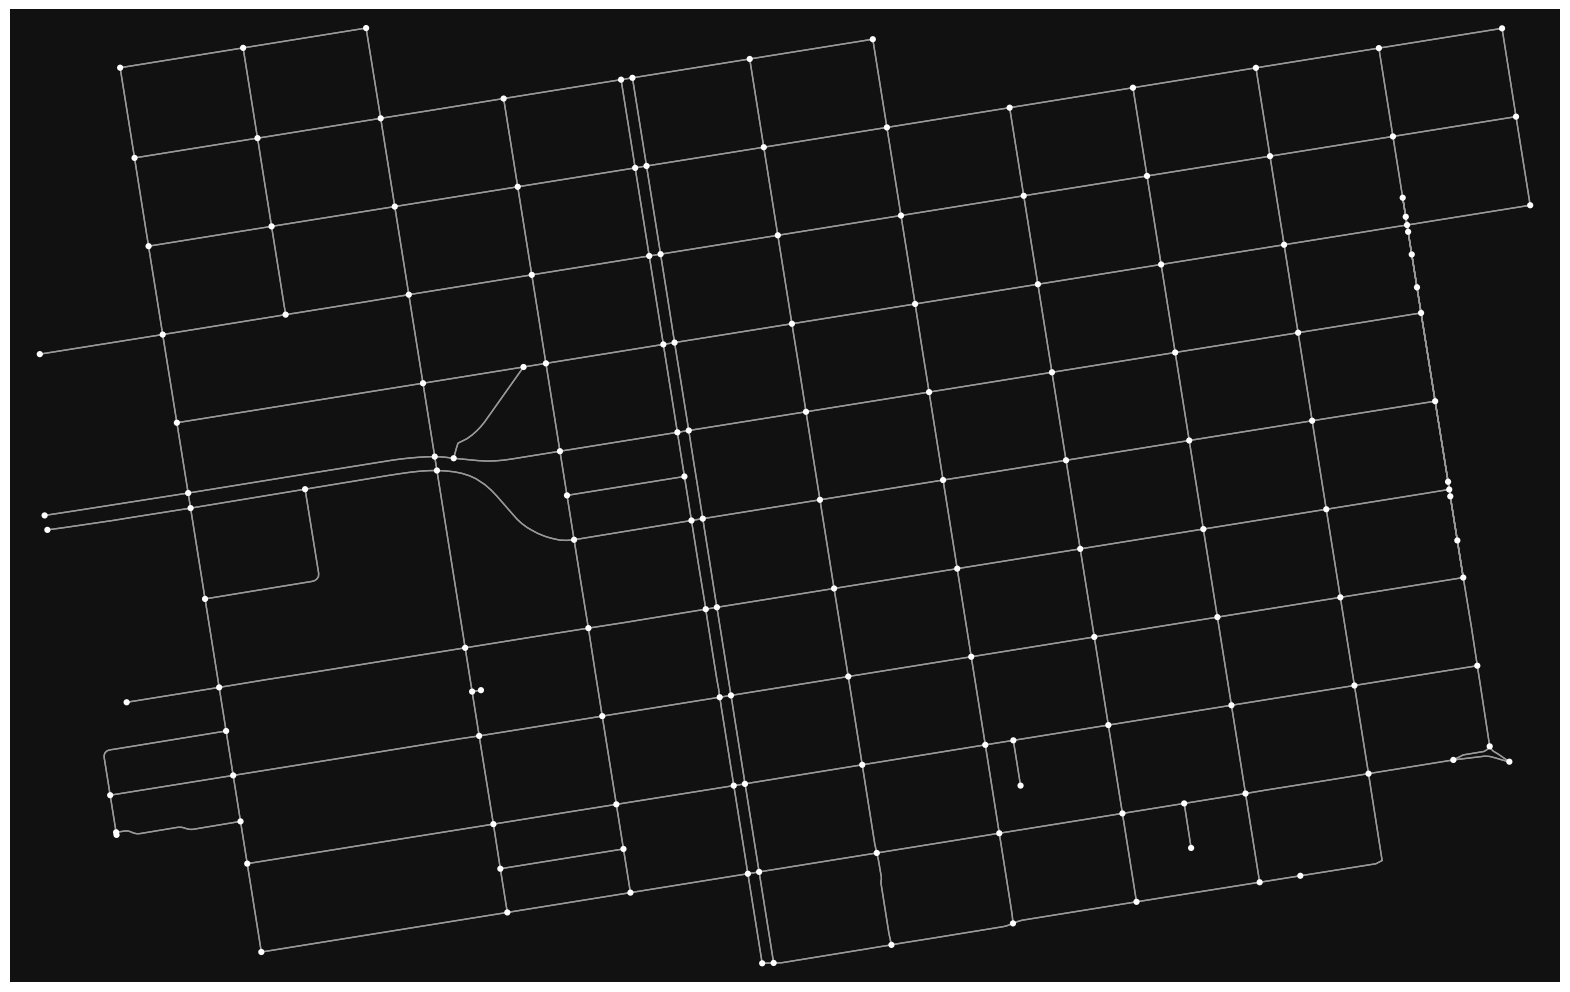

tick: 0
best_candidate was None
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f11dc959d10>, 65295352, 65295347, 20.0, 42.0, 1, 1), None, 42.0)
Rider 12 single hop with 7
best_candidate was None
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f11dc959c50>, 65319958, 65303553, 34.0, 42.0, 1, 1), (<__main__.ContinuousDriverAgent object at 0x7f11dc7be310>, 65303553, 65360270, 44.0, 92.0, 1, 1), 92.0)
Rider 15 multihop with 10 and 3
best_candidate was None
best_candidate is ((<__main__.ContinuousDriverAgent object at 0x7f11dc959d10>, 65319968, 65319961, 72.0, 104.0, 3, 3), None, 104.0)
Rider 20 single hop with 7
tick 1 ended
tick: 1
tick 2 ended
tick: 2
tick 3 ended
tick: 3
tick 4 ended
tick: 4
tick 5 ended
tick: 5
tick 6 ended
tick: 6
tick 7 ended
tick: 7
tick 8 ended
tick: 8
tick 9 ended
tick: 9
tick 10 ended
tick: 10
tick 11 ended
tick: 11
tick 12 ended
tick: 12
tick 13 ended
tick: 13
tick 14 ended
tick: 14
tick 15 ended
tick: 15
tick 16 ended
tick: 16

In [221]:
NB_RUN = 300
MAX_NB_DRIVERS = 10
MAX_NB_RIDERS = 10
DET_FACTOR_D = 0.25
DET_FACTOR_R = 0.5
WT = 4
random.seed(1)

#sma = SMA(place='Lille, France')
sma = SMA(place='grid', show_graph=True, verbose=True, verbose2=True, hop='mhop')
G = sma.G
count_id = 1
for i in range(MAX_NB_DRIVERS):
    v1, v2 = random.sample(list(sma.G.nodes),2)
    while not nx.has_path(sma.G, v1, v2):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        
    d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=DET_FACTOR_D, pref_weight='travel_time',test=False)
    sma.addAgent(d)
    count_id+=1
    
for i in range(MAX_NB_RIDERS):
    v1, v2 = random.sample(list(sma.G.nodes),2)
    while not nx.has_path(sma.G, v1, v2):
        v1, v2 = random.sample(list(sma.G.nodes),2)
    r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT, pref_weight='travel_time')
    sma.addAgent(r)
    count_id+=1
start = timer()

for _ in range(NB_RUN):
    print("tick:",sma.tick)
    sma.runOnce()
end = timer()
print(f'elapsed time: {end - start}')

In [77]:
sma.data

{'d_trip_time': [32.0, 43.0, 50.0, 65.0, 69.0, 75.0, 80.0, 85.0, 136.0, 141.0],
 'd_trip_length': [285.911,
  497.966,
  633.4789999999999,
  747.989,
  843.9780000000001,
  871.224,
  1012.7789999999999,
  985.1019999999999,
  1782.409,
  1701.5190000000002],
 'r_total_waiting_time': [52.0, 27.0, 26.0, 18.0],
 'r_start_waiting_time': [0, 0, 0, 0],
 'r_nb_unmatched': 6,
 'r_nb_matched': 4,
 'mhop_count': 0,
 'shop_count': 4,
 'saved_distance': 1482.1060000000002}

In [ ]:
sma.data

- 1 tick = 1 secondes
- temps : secondes dnas le système, temps d'attente en minutes
- distances : metres
- vitesse : km/h, converti pour les calculs en m/s

### XP1 : Effet du détour conducteur

### XP minimale

In [11]:
TIME_LIMIT = 500 #secondes

NB_RIDERS = 10
WT_R = 3
DET_FACTOR_R = 0.1


NB_DRIVERS = 15
DET_FACTOR_D = [0.25,0.5,0.75,1]
#DET_FACTOR_D = [0.1,0.2]
HOP = ['mhop','shop']
#SEED = [1,6,42,69,48,100,26,35,89,663,559,478,452,236,5789,555,666,777,888,999,111,222,333,444,555]
SEED = [1,2]

results = []

for hop in HOP:
    
    mean_nb_unmatched = []
    mean_waiting_time = []
    mean_trip_length = []
    mean_trip_time = []
    mean_nb_shop = []
    mean_nb_mhop = []
    mean_saved_distance = []
    
        
    for det_d in DET_FACTOR_D:
        local_mean_nb_unmatched = []
        local_mean_waiting_time = []
        local_mean_trip_length = []
        local_mean_trip_time = []
        local_mean_nb_shop = []
        local_mean_nb_mhop = []
        local_mean_saved_distance = []
        
        for seed in SEED:
            random.seed(seed)
            count_id = 0
            sma = SMA(place='grid',show_graph=False, verbose=True, hop=hop)

           
            for i in range(NB_RIDERS):
                v1, v2 = random.sample(list(sma.G.nodes),2)
                while not nx.has_path(sma.G, v1, v2):
                    v1, v2 = random.sample(list(sma.G.nodes),2)
                r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
                sma.addAgent(r)
                count_id+=1



            for i in range(NB_DRIVERS):
                v1, v2 = random.sample(list(sma.G.nodes),2)
                while not nx.has_path(sma.G, v1, v2):
                    v1, v2 = random.sample(list(sma.G.nodes),2)

                d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
                sma.addAgent(d)
                count_id+=1


            for _ in range(TIME_LIMIT):
                if sma.tick%int(TIME_LIMIT/10)==0:
                    print("tick:",sma.tick)             
                sma.runOnce()

            #on récupère les données
            local_mean_trip_time.append(np.mean(sma.data['d_trip_time']))
            print(local_mean_trip_time)
            local_mean_waiting_time.append(np.mean(sma.data['r_waiting_time']))
            print(local_mean_waiting_time)
            local_mean_trip_length.append(np.mean(sma.data['d_trip_length']))
            print(local_mean_trip_length)
            local_mean_nb_unmatched.append(sma.data['r_nb_unmatched'])
            print(local_mean_nb_unmatched)
            local_mean_nb_shop.append(sma.data['shop_count'])
            print(local_mean_nb_shop)
            local_mean_nb_mhop.append(sma.data['mhop_count'])
            print(local_mean_nb_mhop)
            local_mean_saved_distance.append(sma.data['saved_distance'])
            print(local_mean_saved_distance)
            

        mean_trip_time.append((np.mean(local_mean_trip_time),np.std(local_mean_trip_time)))
        mean_waiting_time.append((np.mean(local_mean_waiting_time),np.std(local_mean_waiting_time)))
        mean_trip_length.append((np.mean(local_mean_trip_length),np.std(local_mean_trip_length)))
        mean_nb_unmatched.append((np.mean(local_mean_nb_unmatched),np.std(local_mean_nb_unmatched)))
        mean_nb_shop.append((np.mean(local_mean_nb_shop),np.std(local_mean_nb_shop)))
        mean_nb_mhop.append((np.mean(local_mean_nb_mhop),np.std(local_mean_nb_mhop)))
        mean_saved_distance.append((np.mean(local_mean_saved_distance),np.std(local_mean_saved_distance)))

        print(hop, det_d, "finished.")  
            
    results.append([mean_trip_time, mean_waiting_time, mean_trip_length, mean_nb_unmatched, mean_saved_distance, mean_nb_shop, mean_nb_mhop])

tick: 0
Rider 1 single hop with 18
Rider 3 multihop with 10 and 21
Rider 9 multihop with 19 and 12
tick 1 ended
tick 2 ended
tick 3 ended
tick 4 ended
tick 5 ended
tick 6 ended
tick 7 ended
tick 8 ended
tick 9 ended
tick 10 ended
tick 11 ended
tick 12 ended
tick 13 ended
tick 14 ended
tick 15 ended
tick 16 ended
tick 17 ended
tick 18 ended
tick 19 ended
tick 20 ended
Driver 19 arrived
tick 21 ended
Driver 11 arrived
tick 22 ended
Driver 17 arrived
tick 23 ended
tick 24 ended
tick 25 ended
tick 26 ended
tick 27 ended
tick 28 ended
tick 29 ended
tick 30 ended
Driver 20 arrived
tick 31 ended
tick 32 ended
tick 33 ended
tick 34 ended
tick 35 ended
tick 36 ended
tick 37 ended
tick 38 ended
tick 39 ended
tick 40 ended
tick 41 ended
tick 42 ended
tick 43 ended
tick 44 ended
tick 45 ended
tick 46 ended
tick 47 ended
tick 48 ended
tick 49 ended
tick 50 ended
tick: 50
tick 51 ended
tick 52 ended
tick 53 ended
tick 54 ended
tick 55 ended
Driver 14 arrived
tick 56 ended
tick 57 ended
tick 58 ended

tick 42 ended
tick 43 ended
tick 44 ended
tick 45 ended
tick 46 ended
tick 47 ended
tick 48 ended
tick 49 ended
tick 50 ended
tick: 50
tick 51 ended
tick 52 ended
tick 53 ended
tick 54 ended
tick 55 ended
tick 56 ended
tick 57 ended
tick 58 ended
tick 59 ended
tick 60 ended
tick 61 ended
tick 62 ended
tick 63 ended
tick 64 ended
tick 65 ended
Driver 11 arrived
tick 66 ended
Driver 21 arrived
tick 67 ended
tick 68 ended
tick 69 ended
tick 70 ended
tick 71 ended
tick 72 ended
tick 73 ended
tick 74 ended
tick 75 ended
tick 76 ended
tick 77 ended
tick 78 ended
Driver 13 arrived
tick 79 ended
Driver 16 arrived
tick 80 ended
tick 81 ended
tick 82 ended
tick 83 ended
tick 84 ended
tick 85 ended
tick 86 ended
tick 87 ended
tick 88 ended
tick 89 ended
tick 90 ended
tick 91 ended
tick 92 ended
tick 93 ended
Driver 23 arrived
tick 94 ended
tick 95 ended
Driver 18 arrived
tick 96 ended
tick 97 ended
Driver 10 arrived
tick 98 ended
tick 99 ended
tick 100 ended
tick: 100
tick 101 ended
tick 102 ende

tick 70 ended
tick 71 ended
tick 72 ended
tick 73 ended
tick 74 ended
tick 75 ended
tick 76 ended
tick 77 ended
tick 78 ended
tick 79 ended
tick 80 ended
tick 81 ended
tick 82 ended
tick 83 ended
tick 84 ended
tick 85 ended
tick 86 ended
tick 87 ended
tick 88 ended
tick 89 ended
tick 90 ended
tick 91 ended
tick 92 ended
Driver 24 arrived
tick 93 ended
tick 94 ended
tick 95 ended
tick 96 ended
tick 97 ended
tick 98 ended
tick 99 ended
tick 100 ended
tick: 100
tick 101 ended
tick 102 ended
tick 103 ended
tick 104 ended
tick 105 ended
tick 106 ended
tick 107 ended
tick 108 ended
tick 109 ended
tick 110 ended
tick 111 ended
tick 112 ended
Driver 16 arrived
tick 113 ended
Driver 10 arrived
tick 114 ended
tick 115 ended
tick 116 ended
tick 117 ended
tick 118 ended
tick 119 ended
tick 120 ended
tick 121 ended
tick 122 ended
tick 123 ended
tick 124 ended
tick 125 ended
tick 126 ended
tick 127 ended
tick 128 ended
tick 129 ended
tick 130 ended
tick 131 ended
Driver 13 arrived
tick 132 ended
tic

tick 96 ended
tick 97 ended
Driver 10 arrived
tick 98 ended
tick 99 ended
tick 100 ended
tick: 100
tick 101 ended
tick 102 ended
tick 103 ended
tick 104 ended
tick 105 ended
tick 106 ended
tick 107 ended
tick 108 ended
tick 109 ended
tick 110 ended
tick 111 ended
tick 112 ended
tick 113 ended
tick 114 ended
tick 115 ended
tick 116 ended
tick 117 ended
tick 118 ended
tick 119 ended
tick 120 ended
tick 121 ended
tick 122 ended
tick 123 ended
tick 124 ended
tick 125 ended
tick 126 ended
Driver 18 arrived
tick 127 ended
tick 128 ended
tick 129 ended
tick 130 ended
Driver 20 arrived
tick 131 ended
tick 132 ended
tick 133 ended
tick 134 ended
tick 135 ended
Driver 22 arrived
tick 136 ended
tick 137 ended
tick 138 ended
tick 139 ended
tick 140 ended
tick 141 ended
tick 142 ended
tick 143 ended
tick 144 ended
tick 145 ended
tick 146 ended
tick 147 ended
Driver 24 arrived
tick 148 ended
tick 149 ended
tick 150 ended
tick: 150
Driver 14 arrived
tick 151 ended
tick 152 ended
tick 153 ended
tick 1

tick 96 ended
tick 97 ended
tick 98 ended
tick 99 ended
tick 100 ended
tick: 100
tick 101 ended
tick 102 ended
tick 103 ended
tick 104 ended
tick 105 ended
Driver 15 arrived
tick 106 ended
tick 107 ended
Driver 22 arrived
tick 108 ended
tick 109 ended
tick 110 ended
tick 111 ended
tick 112 ended
tick 113 ended
Driver 10 arrived
tick 114 ended
tick 115 ended
tick 116 ended
tick 117 ended
tick 118 ended
tick 119 ended
tick 120 ended
tick 121 ended
tick 122 ended
tick 123 ended
tick 124 ended
tick 125 ended
tick 126 ended
tick 127 ended
tick 128 ended
tick 129 ended
tick 130 ended
tick 131 ended
Driver 13 arrived
tick 132 ended
tick 133 ended
tick 134 ended
tick 135 ended
tick 136 ended
tick 137 ended
tick 138 ended
tick 139 ended
tick 140 ended
tick 141 ended
tick 142 ended
tick 143 ended
tick 144 ended
Driver 16 arrived
tick 145 ended
tick 146 ended
tick 147 ended
tick 148 ended
tick 149 ended
tick 150 ended
tick: 150
tick 151 ended
tick 152 ended
tick 153 ended
tick 154 ended
tick 155 

tick 110 ended
tick 111 ended
tick 112 ended
tick 113 ended
Driver 18 arrived
tick 114 ended
tick 115 ended
tick 116 ended
tick 117 ended
tick 118 ended
tick 119 ended
tick 120 ended
tick 121 ended
tick 122 ended
tick 123 ended
tick 124 ended
tick 125 ended
tick 126 ended
tick 127 ended
tick 128 ended
tick 129 ended
tick 130 ended
tick 131 ended
Driver 23 arrived
tick 132 ended
tick 133 ended
tick 134 ended
tick 135 ended
tick 136 ended
tick 137 ended
tick 138 ended
tick 139 ended
tick 140 ended
tick 141 ended
tick 142 ended
tick 143 ended
tick 144 ended
tick 145 ended
tick 146 ended
Driver 14 arrived
tick 147 ended
Driver 24 arrived
tick 148 ended
tick 149 ended
tick 150 ended
tick: 150
Driver 20 arrived
tick 151 ended
tick 152 ended
tick 153 ended
tick 154 ended
tick 155 ended
tick 156 ended
tick 157 ended
tick 158 ended
tick 159 ended
tick 160 ended
tick 161 ended
tick 162 ended
tick 163 ended
tick 164 ended
tick 165 ended
tick 166 ended
tick 167 ended
tick 168 ended
Driver 22 arriv

tick: 0
Rider 0 multihop with 18 and 24
Rider 1 single hop with 22
Rider 2 multihop with 23 and 10
Rider 3 single hop with 20
Rider 4 single hop with 14
Rider 5 single hop with 11
Rider 6 multihop with 24 and 14
tick 1 ended
tick 2 ended
tick 3 ended
tick 4 ended
tick 5 ended
tick 6 ended
tick 7 ended
tick 8 ended
tick 9 ended
tick 10 ended
Driver 15 arrived
tick 11 ended
tick 12 ended
tick 13 ended
tick 14 ended
tick 15 ended
tick 16 ended
tick 17 ended
tick 18 ended
tick 19 ended
tick 20 ended
tick 21 ended
tick 22 ended
tick 23 ended
tick 24 ended
tick 25 ended
tick 26 ended
tick 27 ended
tick 28 ended
tick 29 ended
Driver 12 arrived
tick 30 ended
tick 31 ended
tick 32 ended
tick 33 ended
Driver 19 arrived
tick 34 ended
tick 35 ended
tick 36 ended
Driver 17 arrived
tick 37 ended
tick 38 ended
tick 39 ended
tick 40 ended
tick 41 ended
tick 42 ended
tick 43 ended
tick 44 ended
tick 45 ended
tick 46 ended
tick 47 ended
tick 48 ended
tick 49 ended
tick 50 ended
tick: 50
tick 51 ended
ti

tick: 0
Rider 1 single hop with 18
Rider 9 single hop with 12
tick 1 ended
tick 2 ended
tick 3 ended
tick 4 ended
tick 5 ended
tick 6 ended
tick 7 ended
tick 8 ended
tick 9 ended
tick 10 ended
tick 11 ended
tick 12 ended
tick 13 ended
tick 14 ended
tick 15 ended
tick 16 ended
tick 17 ended
tick 18 ended
tick 19 ended
tick 20 ended
tick 21 ended
Driver 11 arrived
tick 22 ended
Driver 17 arrived
tick 23 ended
tick 24 ended
tick 25 ended
tick 26 ended
tick 27 ended
tick 28 ended
tick 29 ended
tick 30 ended
Driver 19 arrived
Driver 20 arrived
tick 31 ended
tick 32 ended
tick 33 ended
tick 34 ended
tick 35 ended
tick 36 ended
tick 37 ended
tick 38 ended
tick 39 ended
tick 40 ended
tick 41 ended
tick 42 ended
tick 43 ended
tick 44 ended
tick 45 ended
tick 46 ended
tick 47 ended
tick 48 ended
tick 49 ended
tick 50 ended
tick: 50
tick 51 ended
tick 52 ended
tick 53 ended
tick 54 ended
tick 55 ended
Driver 14 arrived
tick 56 ended
tick 57 ended
tick 58 ended
tick 59 ended
Driver 22 arrived
tick

tick 35 ended
tick 36 ended
Driver 17 arrived
tick 37 ended
tick 38 ended
tick 39 ended
tick 40 ended
tick 41 ended
tick 42 ended
tick 43 ended
tick 44 ended
tick 45 ended
tick 46 ended
tick 47 ended
tick 48 ended
tick 49 ended
tick 50 ended
tick: 50
tick 51 ended
tick 52 ended
tick 53 ended
tick 54 ended
tick 55 ended
tick 56 ended
tick 57 ended
tick 58 ended
tick 59 ended
tick 60 ended
tick 61 ended
tick 62 ended
tick 63 ended
tick 64 ended
tick 65 ended
Driver 11 arrived
tick 66 ended
Driver 21 arrived
tick 67 ended
tick 68 ended
tick 69 ended
tick 70 ended
tick 71 ended
tick 72 ended
tick 73 ended
tick 74 ended
tick 75 ended
tick 76 ended
tick 77 ended
tick 78 ended
Driver 13 arrived
tick 79 ended
Driver 16 arrived
tick 80 ended
tick 81 ended
tick 82 ended
tick 83 ended
tick 84 ended
tick 85 ended
tick 86 ended
tick 87 ended
tick 88 ended
tick 89 ended
tick 90 ended
tick 91 ended
tick 92 ended
tick 93 ended
Driver 23 arrived
tick 94 ended
tick 95 ended
Driver 18 arrived
tick 96 end

Driver 22 arrived
tick 60 ended
tick 61 ended
tick 62 ended
tick 63 ended
tick 64 ended
tick 65 ended
tick 66 ended
Driver 15 arrived
tick 67 ended
tick 68 ended
Driver 23 arrived
tick 69 ended
tick 70 ended
tick 71 ended
tick 72 ended
tick 73 ended
tick 74 ended
Driver 24 arrived
tick 75 ended
tick 76 ended
tick 77 ended
tick 78 ended
tick 79 ended
tick 80 ended
tick 81 ended
tick 82 ended
tick 83 ended
tick 84 ended
tick 85 ended
tick 86 ended
tick 87 ended
tick 88 ended
Driver 16 arrived
tick 89 ended
tick 90 ended
tick 91 ended
tick 92 ended
tick 93 ended
tick 94 ended
tick 95 ended
tick 96 ended
tick 97 ended
tick 98 ended
tick 99 ended
tick 100 ended
tick: 100
tick 101 ended
tick 102 ended
tick 103 ended
tick 104 ended
tick 105 ended
tick 106 ended
tick 107 ended
tick 108 ended
tick 109 ended
tick 110 ended
tick 111 ended
tick 112 ended
tick 113 ended
Driver 10 arrived
tick 114 ended
tick 115 ended
tick 116 ended
tick 117 ended
tick 118 ended
tick 119 ended
tick 120 ended
tick 12

tick 97 ended
Driver 10 arrived
tick 98 ended
tick 99 ended
tick 100 ended
tick: 100
tick 101 ended
tick 102 ended
tick 103 ended
tick 104 ended
tick 105 ended
Driver 20 arrived
tick 106 ended
tick 107 ended
tick 108 ended
tick 109 ended
tick 110 ended
Driver 18 arrived
tick 111 ended
Driver 24 arrived
tick 112 ended
tick 113 ended
tick 114 ended
tick 115 ended
tick 116 ended
tick 117 ended
tick 118 ended
tick 119 ended
tick 120 ended
tick 121 ended
tick 122 ended
tick 123 ended
tick 124 ended
tick 125 ended
tick 126 ended
tick 127 ended
tick 128 ended
tick 129 ended
tick 130 ended
tick 131 ended
tick 132 ended
tick 133 ended
tick 134 ended
tick 135 ended
tick 136 ended
Driver 22 arrived
tick 137 ended
tick 138 ended
tick 139 ended
tick 140 ended
tick 141 ended
tick 142 ended
tick 143 ended
tick 144 ended
tick 145 ended
tick 146 ended
tick 147 ended
tick 148 ended
tick 149 ended
tick 150 ended
tick: 150
Driver 14 arrived
tick 151 ended
tick 152 ended
tick 153 ended
tick 154 ended
tick 

tick 176 ended
tick 177 ended
tick 178 ended
tick 179 ended
Rider 2 cancels.
Rider 4 cancels.
Rider 7 cancels.
Rider 9 cancels.
tick 180 ended
tick 181 ended
tick 182 ended
tick 183 ended
tick 184 ended
tick 185 ended
tick 186 ended
tick 187 ended
tick 188 ended
tick 189 ended
tick 190 ended
tick 191 ended
tick 192 ended
tick 193 ended
tick 194 ended
tick 195 ended
tick 196 ended
tick 197 ended
Driver 18 arrived
tick 198 ended
tick 199 ended
tick 200 ended
tick: 200
tick 201 ended
tick 202 ended
tick 203 ended
tick 204 ended
tick 205 ended
tick 206 ended
tick 207 ended
Driver 12 arrived
tick 208 ended
tick 209 ended
Driver 21 arrived
tick 210 ended
tick 211 ended
tick 212 ended
tick 213 ended
tick 214 ended
tick 215 ended
tick 216 ended
tick 217 ended
tick 218 ended
tick 219 ended
tick 220 ended
tick 221 ended
tick 222 ended
tick 223 ended
tick 224 ended
tick 225 ended
tick 226 ended
tick 227 ended
tick 228 ended
tick 229 ended
tick 230 ended
tick 231 ended
tick 232 ended
tick 233 ende

tick: 0
Rider 0 single hop with 24
Rider 1 single hop with 13
Rider 3 single hop with 10
Rider 4 single hop with 12
Rider 5 single hop with 16
Rider 6 single hop with 21
Rider 8 single hop with 18
tick 1 ended
tick 2 ended
tick 3 ended
tick 4 ended
tick 5 ended
tick 6 ended
tick 7 ended
tick 8 ended
tick 9 ended
tick 10 ended
tick 11 ended
tick 12 ended
tick 13 ended
tick 14 ended
tick 15 ended
tick 16 ended
tick 17 ended
tick 18 ended
tick 19 ended
tick 20 ended
tick 21 ended
Driver 11 arrived
tick 22 ended
Driver 17 arrived
tick 23 ended
tick 24 ended
tick 25 ended
tick 26 ended
tick 27 ended
tick 28 ended
tick 29 ended
tick 30 ended
Driver 19 arrived
Driver 20 arrived
tick 31 ended
tick 32 ended
tick 33 ended
tick 34 ended
tick 35 ended
tick 36 ended
tick 37 ended
tick 38 ended
tick 39 ended
tick 40 ended
tick 41 ended
tick 42 ended
tick 43 ended
tick 44 ended
tick 45 ended
tick 46 ended
tick 47 ended
tick 48 ended
tick 49 ended
tick 50 ended
tick: 50
tick 51 ended
tick 52 ended
tic

Rider 4 single hop with 14
Rider 5 single hop with 11
Rider 9 single hop with 20
tick 1 ended
tick 2 ended
tick 3 ended
tick 4 ended
tick 5 ended
tick 6 ended
tick 7 ended
tick 8 ended
tick 9 ended
tick 10 ended
Driver 15 arrived
tick 11 ended
tick 12 ended
tick 13 ended
tick 14 ended
tick 15 ended
tick 16 ended
tick 17 ended
tick 18 ended
tick 19 ended
tick 20 ended
tick 21 ended
tick 22 ended
tick 23 ended
tick 24 ended
tick 25 ended
tick 26 ended
tick 27 ended
tick 28 ended
tick 29 ended
Driver 12 arrived
tick 30 ended
tick 31 ended
tick 32 ended
tick 33 ended
Driver 19 arrived
tick 34 ended
tick 35 ended
tick 36 ended
Driver 17 arrived
tick 37 ended
tick 38 ended
tick 39 ended
tick 40 ended
tick 41 ended
tick 42 ended
tick 43 ended
tick 44 ended
tick 45 ended
tick 46 ended
tick 47 ended
tick 48 ended
tick 49 ended
tick 50 ended
tick: 50
tick 51 ended
tick 52 ended
tick 53 ended
tick 54 ended
tick 55 ended
tick 56 ended
tick 57 ended
tick 58 ended
tick 59 ended
tick 60 ended
tick 61

ValueError: x and y must have same first dimension, but have shapes (9,) and (4,)

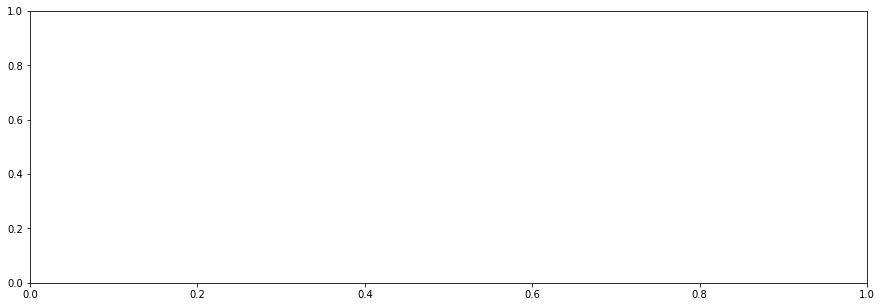

In [71]:
# entries = ["Mean trip time of drivers (s)", "Mean total waiting time of riders (s)", 
#            "Mean trip length of drivers (meters)", "Number of unmatched riders", "Saved distance (meters)"]

# for i in range(len(entries)) :
#     f = plt.figure(figsize=(15, 5))
#     for j in range(len(HOP)):
#         avg = [x for x,_ in results[j][i]]
#         std = [x for _,x in results[j][i]]
#         plt.plot(DET_FACTOR_D, avg, label = HOP[j])
#         plt.fill_between(DET_FACTOR_D, np.add(avg,std), np.subtract(avg,std), alpha=0.2)

#     plt.xlabel('Drivers detour')
#     plt.ylabel(entries[i])
#     plt.legend()
    
#     #entry = entries[i].replace(' ','_').split("(")[0]
#     #path = '/home/fevrec/Documents/These/these/smac_agents/img/paper_v3/xp2/raw/'+entry+'_max_d_'+str(MAX_NB_DRIVERS[-1])+'.pdf'
#     #plt.savefig(path)
#     plt.show()

### XP minimale multi processing (le bon pour le moment)

In [86]:
import time
from timeit import default_timer as timer
from multiprocessing import Pool, cpu_count

def power(hop, det_d):
    print(hop,det_d,"begins")
    TIME_LIMIT = 500 #secondes
    NB_RUN = 50
    NB_RIDERS = 10
    WT_R = 3
    DET_FACTOR_R = 0.2

    NB_DRIVERS = 15
    
    #seed = 1

    trip_time=[]
    start_waiting_time=[]
    total_waiting_time=[]
    trip_length=[]
    nb_unmatched=[]
    nb_matched=[]
    nb_shop=[]
    nb_mhop=[]
    saved_distance=[] 
        
    for j in range(NB_RUN):
        #random.seed(seed)
        count_id = 0
        global sma
        sma = SMA(place='grid', show_graph=False, verbose=False, hop=hop)


        for i in range(NB_RIDERS):
            v1, v2 = random.sample(list(sma.G.nodes),2)
            while not nx.has_path(sma.G, v1, v2):
                v1, v2 = random.sample(list(sma.G.nodes),2)
            r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
            sma.addAgent(r)
            count_id+=1



        for i in range(NB_DRIVERS):
            v1, v2 = random.sample(list(sma.G.nodes),2)
            while not nx.has_path(sma.G, v1, v2):
                v1, v2 = random.sample(list(sma.G.nodes),2)

            d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
            sma.addAgent(d)
            count_id+=1


        for _ in range(TIME_LIMIT):
            if sma.tick%int(TIME_LIMIT/4)==0:
                print("tick:",sma.tick)             
            sma.runOnce()
            
        #print(hop,det_d,"run",i,"finished")    
        trip_time.extend(sma.data['d_trip_time'])
        total_waiting_time.extend(sma.data['r_total_waiting_time'])
        start_waiting_time.extend(sma.data['r_start_waiting_time'])
        trip_length.extend(sma.data['d_trip_length'])
        nb_unmatched.extend([sma.data['r_nb_unmatched']])
        nb_matched.extend([sma.data['r_nb_matched']])
        nb_shop.extend([sma.data['shop_count']])
        nb_mhop.extend([sma.data['mhop_count']])
        saved_distance.extend([sma.data['saved_distance']])  
        print(hop,det_d,"run",j,"finished")

        

        
    print(hop,det_d,"finished")        
    
    return [hop, det_d, trip_time, trip_length, start_waiting_time, total_waiting_time,  nb_unmatched, nb_matched, saved_distance, nb_shop, nb_mhop]


def main():
    DET_FACTOR_D = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
    HOP = ['mhop','shop']
    values = []
    res3 = None
    #DET_FACTOR_D = [0.1,0.2]
    for hop in HOP:
        for det_d in DET_FACTOR_D:
            values.append((hop,det_d))
   
    start = timer()

    print(f'starting computations on {cpu_count()} cores')

    with Pool() as pool:
        res3 = pool.starmap(power, values)
        print(res3)

    end = timer()
    print(f'elapsed time: {end - start}')
    return res3

if __name__ == '__main__':
    res3 = main()

starting computations on 16 cores
mhop 0.9 begins
mhop 0.6 begins
mhop 0.8 begins
mhop 0.7 begins
mhop 1 begins
mhop 0.5 begins
shop 1 begins
shop 0.6 begins
shop 0.7 begins
mhop 0.1 begins
mhop 0.3 begins
mhop 0.4 begins
shop 0.8 begins
shop 0.5 begins
shop 0.9 begins
mhop 0.2 begins
tick: 0
tick: 0
tick: 0
tick: 0
tick: 0
tick: 0
tick: 0
tick: 0
tick: 0
tick: 0
tick: 0
tick: 0
tick: 0
tick: 0
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.7 run 0 finished
tick: 125
tick: 250
tick: 375
shop 0.6 run 0 finished
tick: 125
tick: 250
tick: 375
mhop 0.1 run 0 finished
tick: 0
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.5 run 0 finished
tick: 125
tick: 250
tick: 375
shop 0.9 run 0 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.8 run 0 finished
tick: 125
tick: 250
tick: 375
shop 1 run 0 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.5 run 1 finished
tick: 125
tick: 250
tick: 375
mhop 0.1 run 1 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375


tick: 375
mhop 0.3 run 3 finished
tick: 250
tick: 375
shop 0.5 run 17 finished
tick: 125
tick: 250
tick: 375
mhop 0.2 run 6 finished
tick: 0
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 1 run 14 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.6 run 2 finished
tick: 125
tick: 125
tick: 250
tick: 375
mhop 0.1 run 12 finished
tick: 125
tick: 250
tick: 375
shop 0.8 run 14 finished
tick: 250
tick: 375
shop 0.7 run 15 finished
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.6 run 16 finished
tick: 0
tick: 0
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.9 run 14 finished
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.5 run 18 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 1 run 1 finished
tick: 125
tick: 250
tick: 375
mhop 0.1 run 13 finished
tick: 0
tick: 125
tick: 250
tick: 375
shop 1 run 15 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.7 run 16 finished
tick: 125
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.6 run 17 finished
tick: 250
tick: 375
shop 0.8 r

tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 1 run 28 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.9 run 2 finished
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.8 run 28 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.7 run 30 finished
tick: 125
tick: 250
tick: 375
shop 0.6 run 32 finished
tick: 0
tick: 125
tick: 0
tick: 250
tick: 375
mhop 0.8 run 3 finished
tick: 125
tick: 250
tick: 375
shop 0.5 run 36 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.1 run 23 finished
tick: 125
tick: 0
tick: 250
tick: 375
shop 0.9 run 28 finished
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.8 run 29 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.2 run 13 finished
tick: 125
tick: 250
tick: 375
shop 1 run 29 finished
tick: 0
tick: 125
tick: 125
tick: 250
tick: 375
shop 0.6 run 33 finished
tick: 250
tick: 375
shop 0.7 run 31 finished
tick: 125
tick: 0
tick: 250
tick: 375
shop 0.5 run 37 finished
tick: 0
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.

tick: 250
tick: 375
mhop 0.1 run 34 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.2 run 20 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.4 run 3 finished
tick: 0
tick: 125
tick: 250
tick: 375
shop 1 run 42 finished
tick: 125
tick: 250
tick: 375
shop 0.7 run 46 finished
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.8 run 43 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.6 run 48 finished
tick: 125
tick: 250
tick: 375
shop 0.9 run 42 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.1 run 35 finished
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.4 run 4 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.3 run 13 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.7 run 6 finished
tick: 125
tick: 250
tick: 375
shop 0.7 run 47 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 1 run 43 finished
tick: 125
tick: 250
tick: 375
shop 0.6 run 49 finished
shop 0.6 finished
shop 0.3 begins
tick: 0
tick: 125
tick: 125
tick: 250
tick: 37

shop 0.3 run 15 finished
tick: 125
tick: 250
tick: 375
shop 0.2 run 15 finished
tick: 0
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.4 run 20 finished
tick: 125
tick: 250
tick: 375
mhop 0.1 run 46 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.1 run 15 finished
tick: 125
tick: 250
tick: 375
shop 0.3 run 16 finished
tick: 125
tick: 0
tick: 250
tick: 375
shop 0.2 run 16 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.1 run 16 finished
tick: 0
tick: 125
tick: 125
tick: 250
tick: 375
mhop 0.2 run 27 finished
tick: 250
tick: 375
shop 0.2 run 17 finished
tick: 125
tick: 250
tick: 375
shop 0.4 run 21 finished
tick: 125
tick: 0
tick: 0
tick: 250
tick: 375
shop 0.1 run 17 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.3 run 17 finished
tick: 125
tick: 250
tick: 375
mhop 0.3 run 17 finished
tick: 125
tick: 125
tick: 0
tick: 250
tick: 375
tick: 250
mhop 0.8 run 7 finished
tick: 375
mhop 0.6 run 10 finished
tick: 125
tick: 250
tick: 375
shop 0.1 

tick: 125
tick: 250
tick: 375
mhop 0.4 run 15 finished
tick: 125
tick: 250
tick: 375
shop 0.2 run 39 finished
tick: 0
tick: 0
tick: 0
tick: 0
tick: 125
tick: 125
tick: 250
tick: 375
shop 0.1 run 48 finished
tick: 250
tick: 375
mhop 1 run 8 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.4 run 38 finished
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.3 run 37 finished
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.1 run 49 finished
shop 0.1 finished
tick: 125
tick: 250
tick: 375
shop 0.2 run 40 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.2 run 34 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.3 run 22 finished
tick: 125
tick: 250
tick: 375
shop 0.4 run 39 finished
tick: 0
tick: 0
tick: 125
tick: 125
tick: 250
tick: 375
shop 0.3 run 38 finished
tick: 250
tick: 375
shop 0.2 run 41 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
shop 0.2 run 42 finished
tick: 125
tick: 250
tick: 375
shop 0.4 run 40 finished
tick: 0
tick: 0
tick: 125
tick: 125
tick: 250
ti

mhop 0.5 run 22 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.7 run 19 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.6 run 22 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.4 run 27 finished
tick: 0
tick: 125
tick: 125
tick: 250
tick: 375
mhop 0.9 run 15 finished
tick: 250
tick: 375
mhop 0.8 run 16 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.5 run 23 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.3 run 40 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.3 run 41 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.8 run 17 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.7 run 20 finished
tick: 125
tick: 250
tick: 375
mhop 0.5 run 24 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.4 run 28 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.6 run 23 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.3 run 42 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.5 run 25 finished
tick: 0
tick: 125
tick

tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
mhop 1 run 27 finished
tick: 125
tick: 250
tick: 375
mhop 0.9 run 30 finished
tick: 0
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.8 run 29 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.5 run 47 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.7 run 34 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.6 run 40 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.8 run 30 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.5 run 48 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.9 run 31 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.7 run 35 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.6 run 41 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.8 run 31 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.5 run 49 finished
mhop 0.5 finished
tick: 125
tick: 250
tick: 375
mhop 1 run 28 finished
tick: 0
tick: 125
tick: 250
tick: 375
mhop 0.6 run 42 finished
tick: 0
tick: 125
tick: 250
tick: 375
mho

In [87]:
import csv
with open('/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp_conf_ieee/xp2_50run/data.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(res3)
    

In [90]:
show_res3 = []
mean_trip_time = []
mean_trip_length = []
mean_start_waiting_time = []
mean_total_waiting_time = []
mean_nb_unmatched = []
mean_nb_matched = []
mean_saved_distance = [] 

for i in range(len(res3)):
    mean_trip_time.insert(0,(np.mean(res3[i][2])/60,np.std(res3[i][2])/60))
    mean_trip_length.insert(0,(np.mean(res3[i][3])/1000,np.std(res3[i][3])/1000))
    mean_start_waiting_time.insert(0,(np.mean(res3[i][4])/60,np.std(res3[i][4])/60))
    mean_total_waiting_time.insert(0,(np.mean(res3[i][5])/60,np.std(res3[i][5])/60))
    mean_nb_unmatched.insert(0,(np.mean(res3[i][6]),np.std(res3[i][6]))) #meme si une seule valeur
    mean_nb_matched.insert(0,(np.mean(res3[i][7]),np.std(res3[i][7]))) #meme si une seule valeur
    mean_saved_distance.insert(0,(np.mean(res3[i][8])/1000,np.std(res3[i][8])/1000))
    if i == 9 or i == len(res3)-1:
        show_res3.append([mean_trip_time, mean_trip_length, mean_start_waiting_time, mean_total_waiting_time, mean_nb_unmatched, mean_nb_matched, mean_saved_distance])
        mean_trip_time = []
        mean_trip_length = []
        mean_start_waiting_time = []
        mean_total_waiting_time = []
        mean_nb_unmatched = []
        mean_nb_matched = []
        mean_saved_distance = []  
        
show_res3

[[[(1.3131333333333333, 0.566532432467054),
   (1.3074222222222223, 0.6180738475195777),
   (1.3479333333333334, 0.6408361054700914),
   (1.4297555555555554, 0.7239046485877222),
   (1.4636444444444445, 0.7684239133559575),
   (1.5703333333333334, 0.86210137326058),
   (1.5969111111111112, 0.893149906265308),
   (1.7004888888888887, 0.9603289086763482),
   (1.7138666666666666, 0.9993369713075876),
   (1.7889111111111111, 1.055884568373075)],
  [(0.9428687200000001, 0.4590357179455373),
   (0.9377385013333333, 0.5003086459435102),
   (0.9646261706666667, 0.514412865838661),
   (1.0277711706666666, 0.5837872114064692),
   (1.0514970293333332, 0.6125624503133628),
   (1.138817284, 0.6875972019880655),
   (1.1599705053333331, 0.713698475923861),
   (1.240041688, 0.764648083909253),
   (1.2529416560000002, 0.7918017721637737),
   (1.3040008133333336, 0.8428846020331243)],
  [(0.0, 0.0),
   (0.0, 0.0),
   (0.0, 0.0),
   (0.0, 0.0),
   (0.0, 0.0),
   (0.0, 0.0),
   (0.0, 0.0),
   (0.0, 0.0),


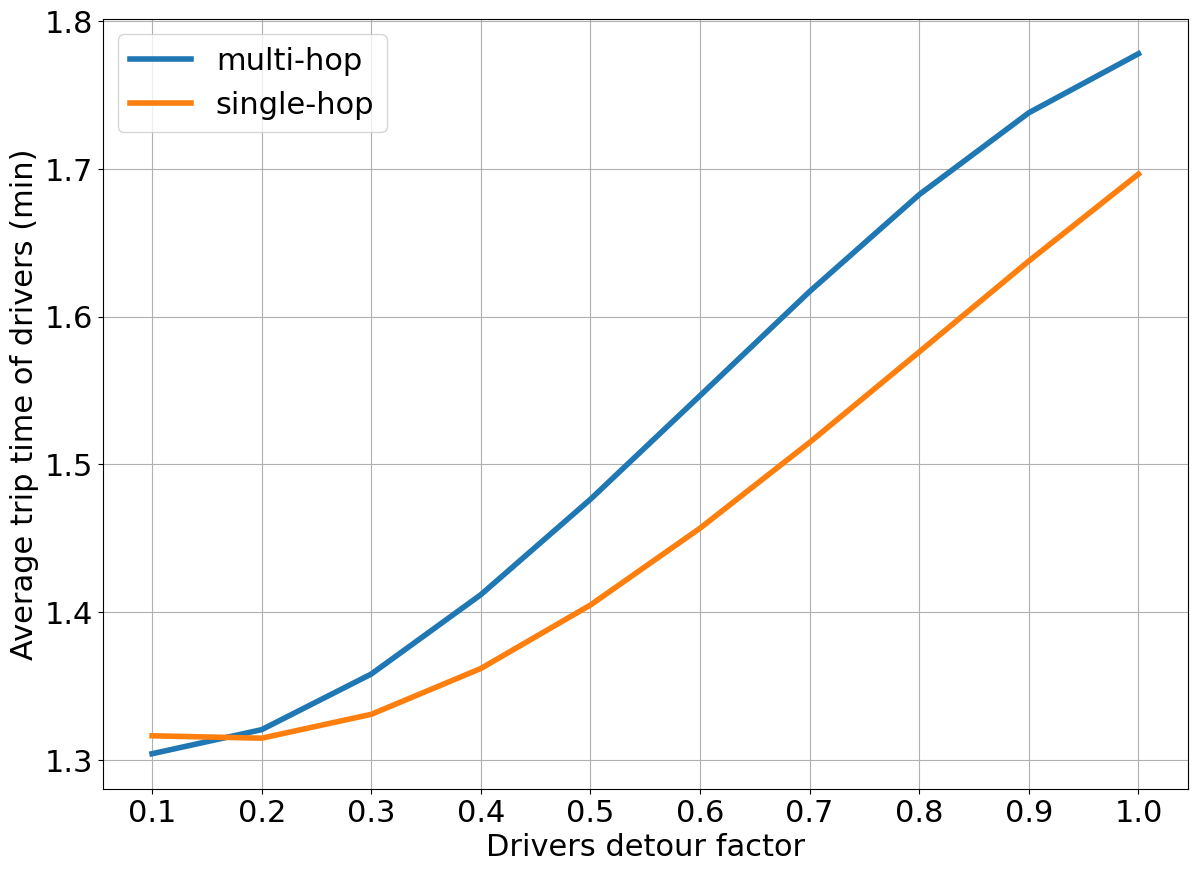

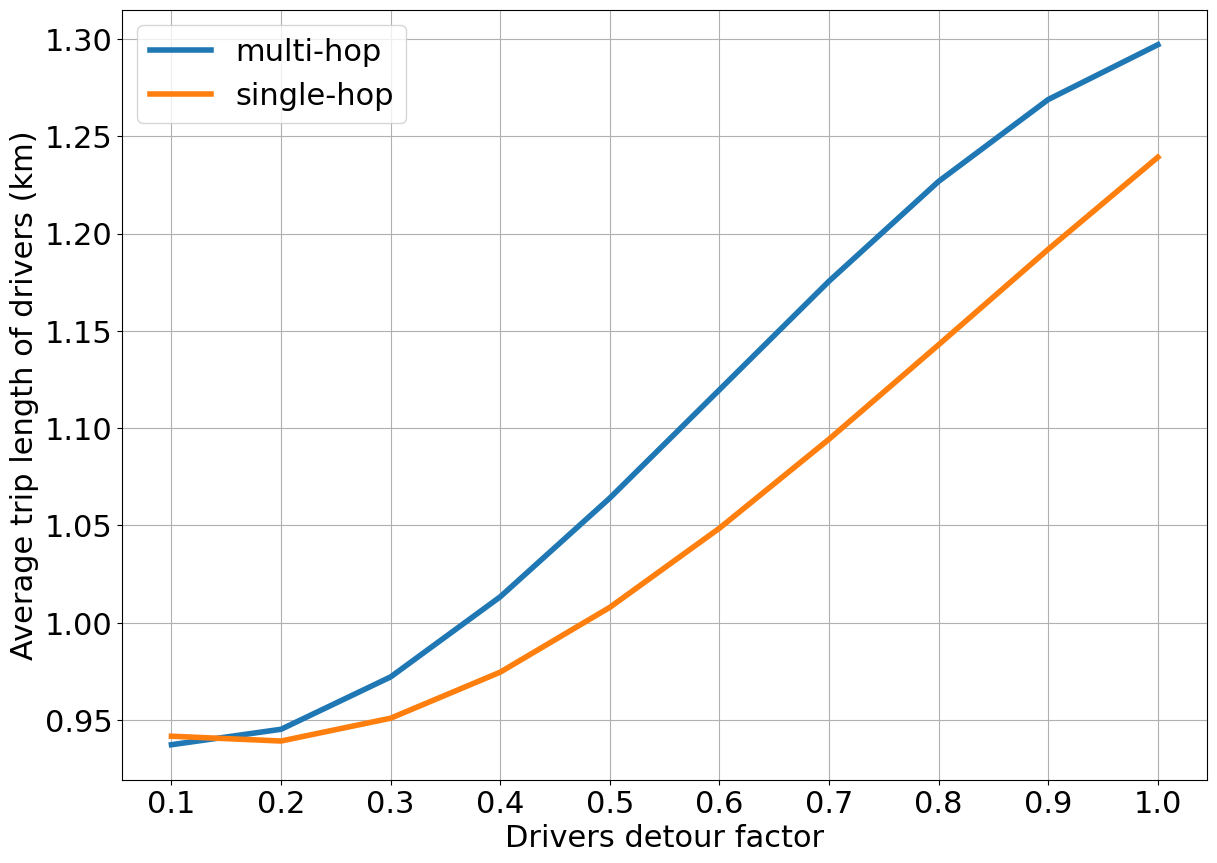

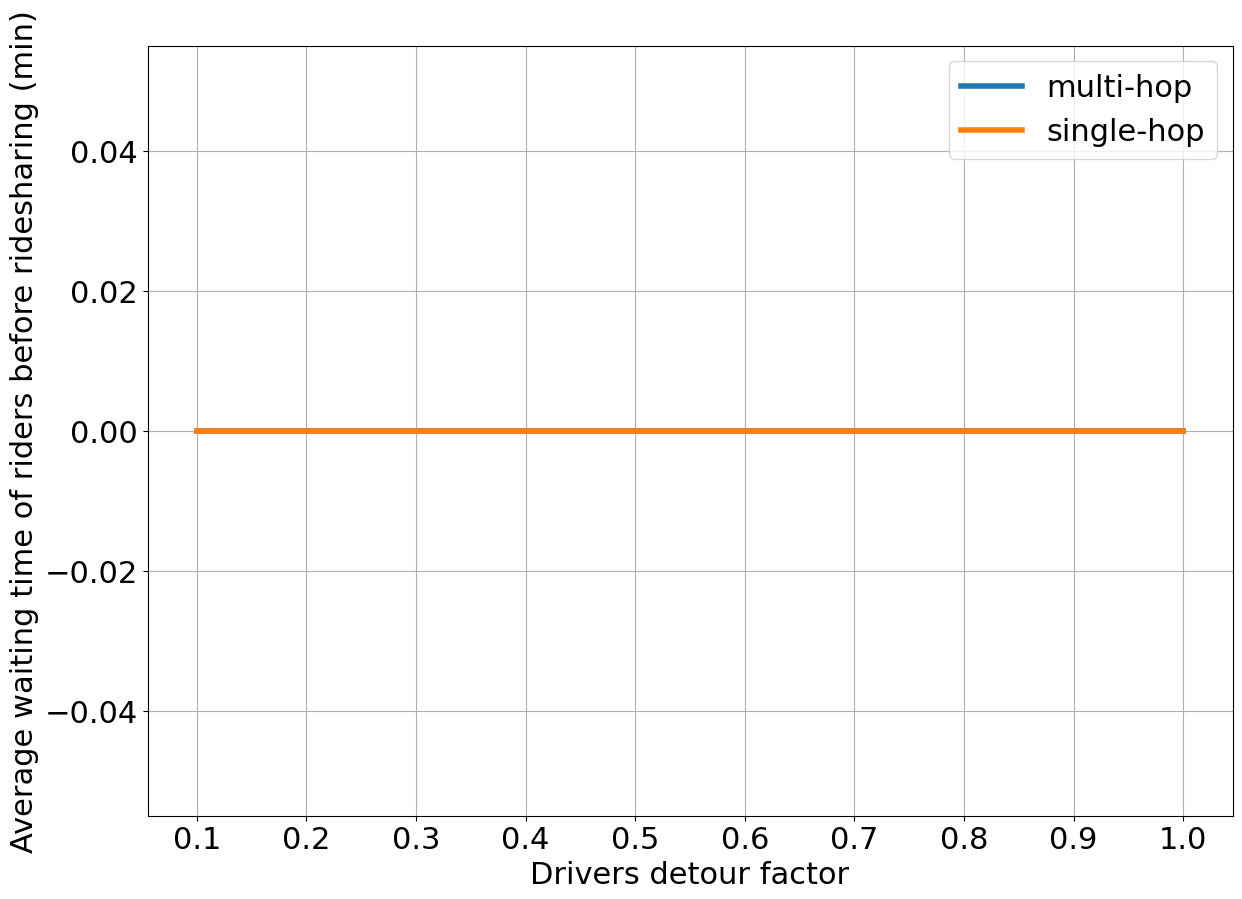

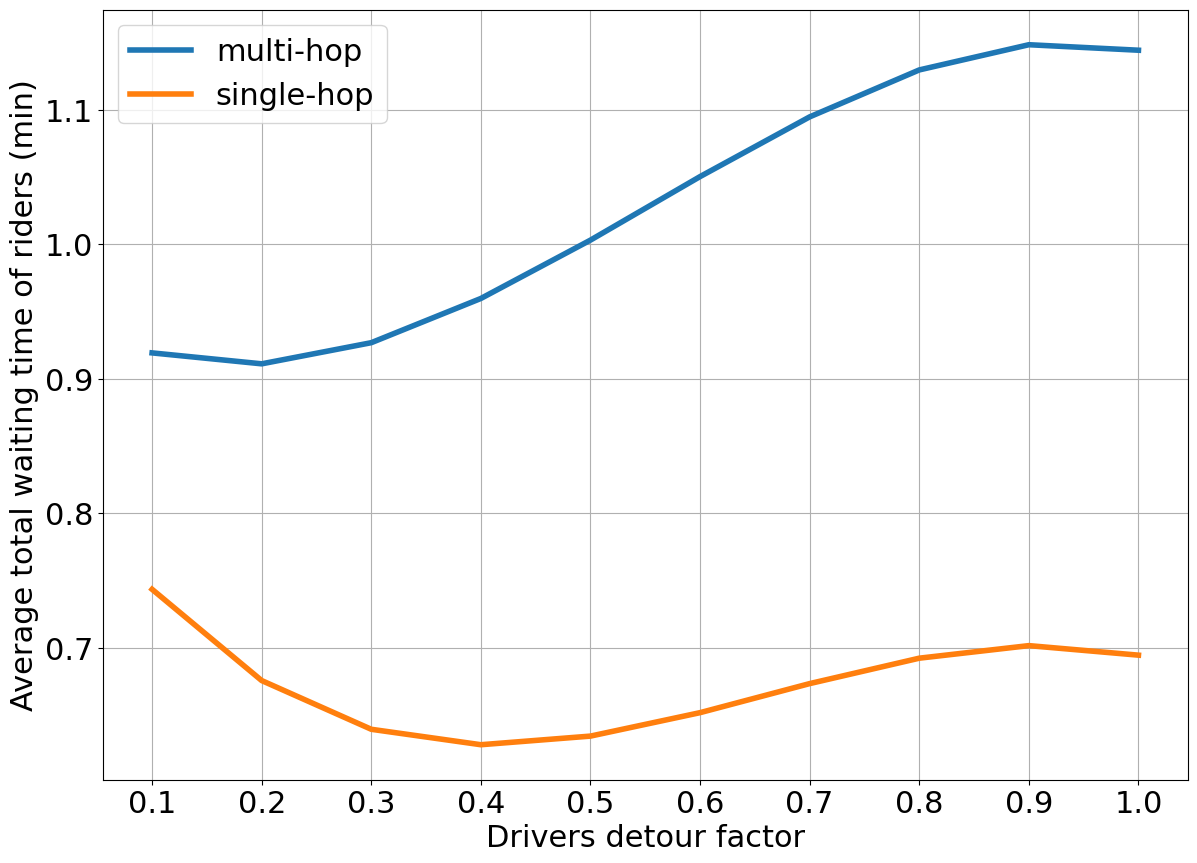

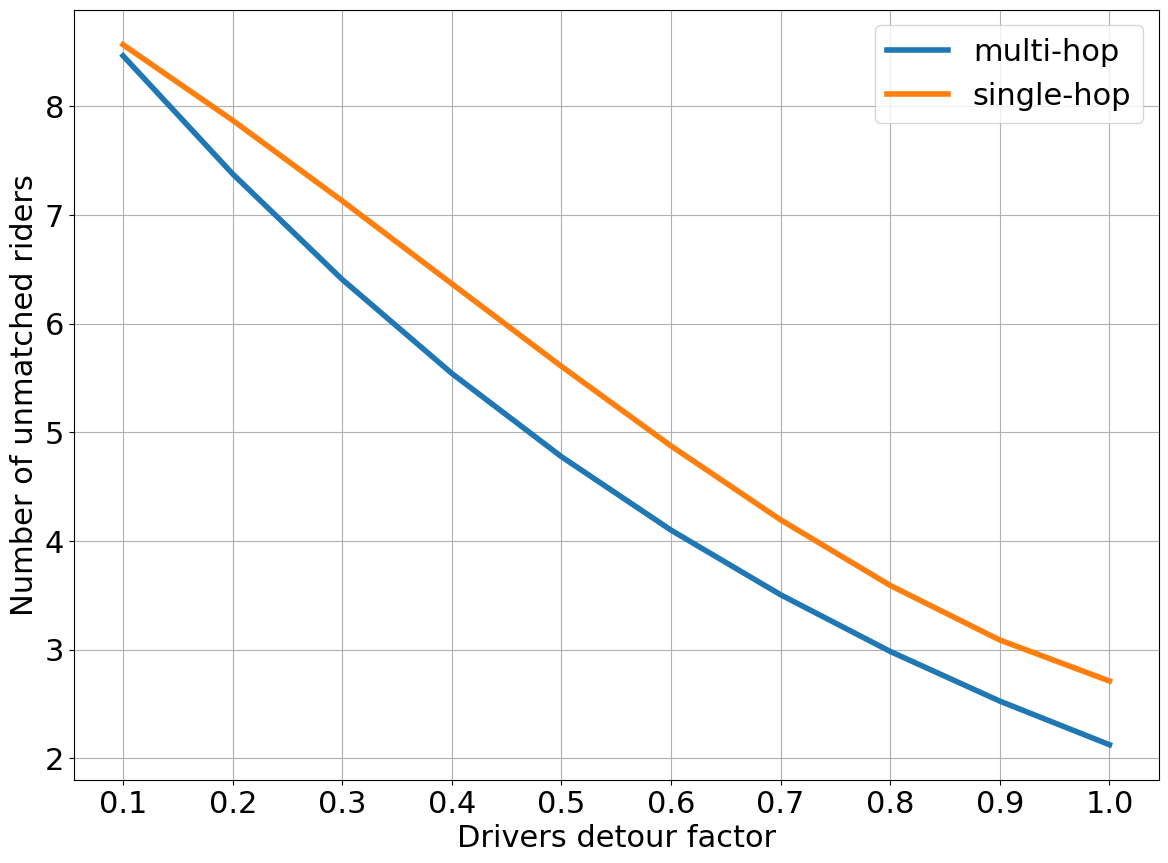

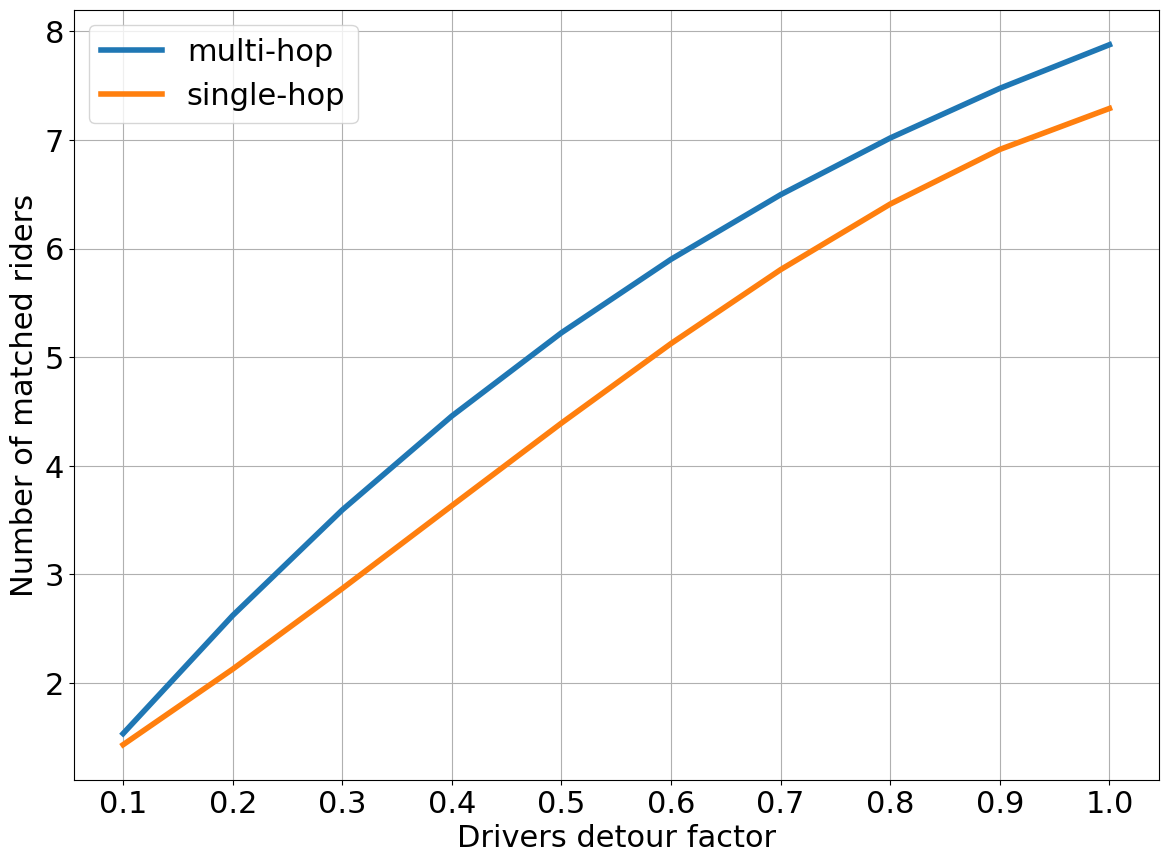

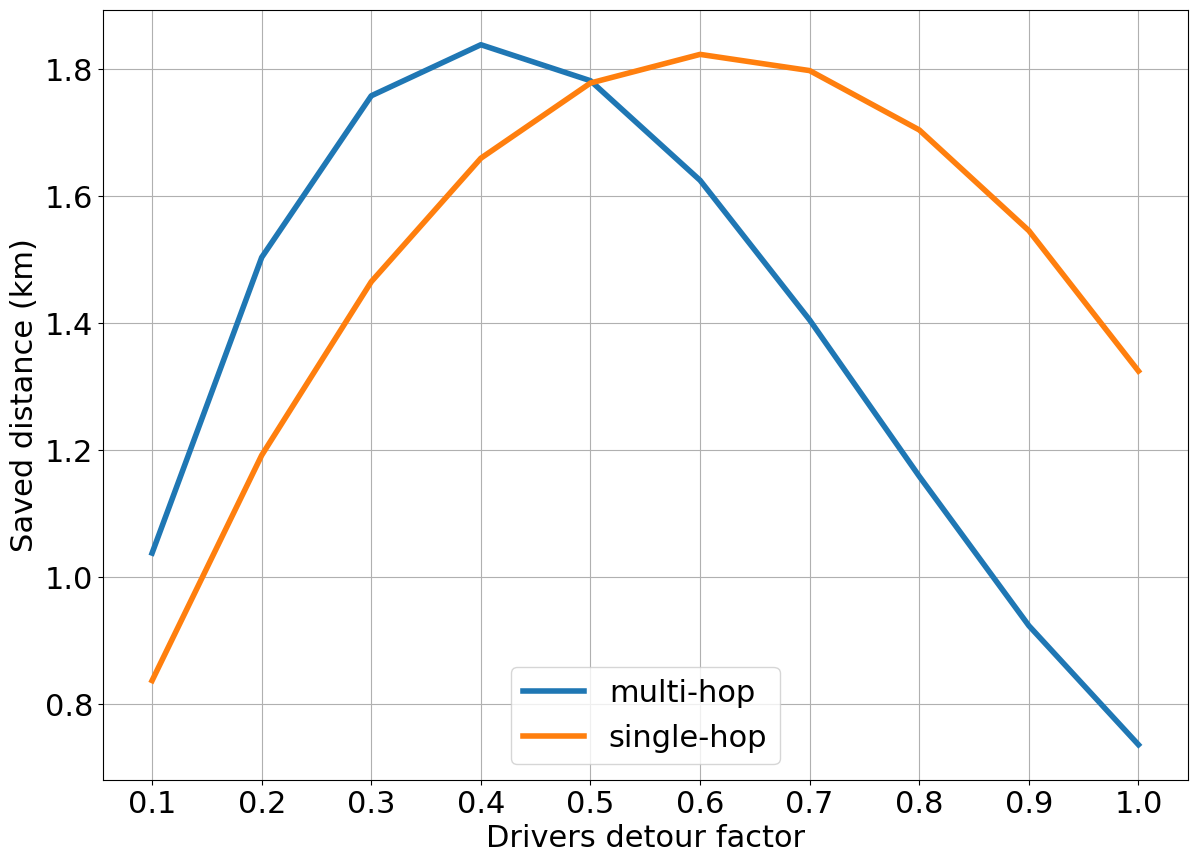

In [207]:
plt.style.use('default')
plt.rcParams.update({'font.size': 22})
#plt.style.use('fivethirtyeight')

entries = ["Average trip time of drivers (min)","Average trip length of drivers (km)","Average waiting time of riders before ridesharing (min)", "Average total waiting time of riders (min)",
            "Number of unmatched riders","Number of matched riders", "Saved distance (km)"]
DET_FACTOR_D = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
HOP = ['multi-hop','single-hop']
for i in range(len(entries)) :
    f = plt.figure(figsize=(14, 10))
    for j in range(len(HOP)):
        avg = [x for x,_ in show_res3[j][i]]
        poly_avg = np.polyfit(DET_FACTOR_D,avg,3) 
        poly_y_avg = np.poly1d(poly_avg)(DET_FACTOR_D)
        
        
        #std = [x for _,x in show_res3[j][i]]
        #poly_std = np.polyfit(DET_FACTOR_D,std,3) 
        #poly_y_std = np.poly1d(poly_std)(DET_FACTOR_D)
        #plt.plot(DET_FACTOR_D, avg, label = HOP[j])
        plt.plot(DET_FACTOR_D, poly_y_avg, label = HOP[j],linewidth=4)
        #plt.fill_between(DET_FACTOR_D, np.add(avg,std), np.subtract(avg,std), alpha=0.2)
    plt.grid()
    plt.xlabel('Drivers detour factor')
    plt.ylabel(entries[i])
    plt.xticks(np.arange(0.1, 1.1, 0.1))
    plt.legend()
    
    entry = entries[i].replace(' ','_').split("(")[0]
    path = '/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp_conf_ieee/xp2_50run/'+entry+'.png'
    plt.savefig(path,format='png', dpi=400)
    plt.show()

In [190]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


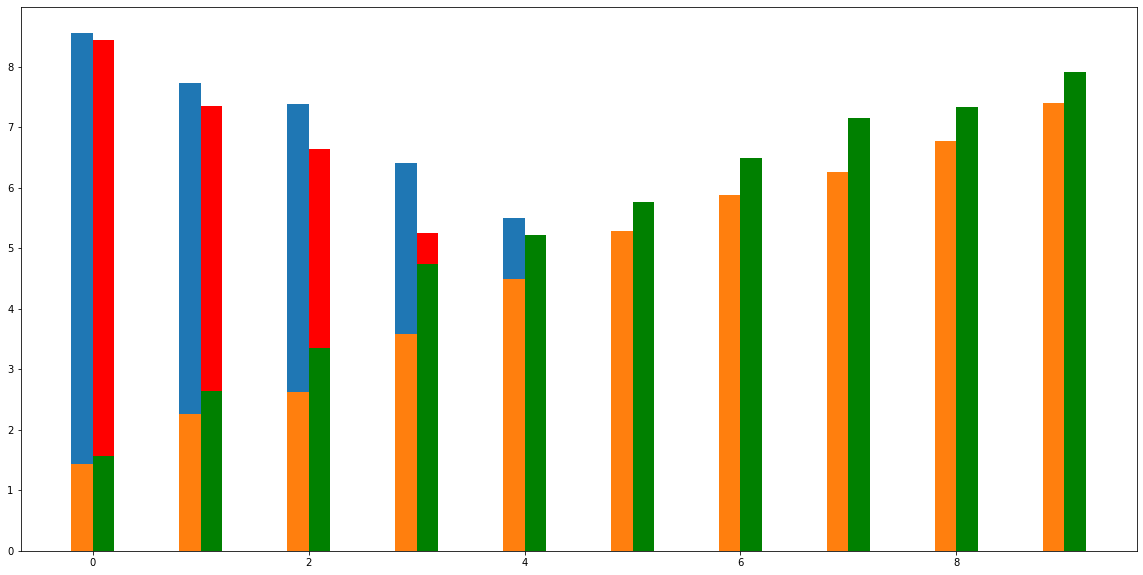

In [121]:
import pandas as pd

fig = plt.figure(figsize=(20, 10))

size = list(np.arange(10))
ab_bar_list = [plt.bar(size, [x for x,_ in show_res3[0][4]], align='edge', width= 0.2 , color='red'),
               plt.bar(size, [x for x,_ in show_res3[0][5]], align='edge', width= 0.2, color='green')]

cd_bar_list = [plt.bar(size, [x for x,_ in show_res3[1][4]], align='edge',width= -0.2),
               plt.bar(size, [x for x,_ in show_res3[1][5]], align='edge',width= -0.2)]

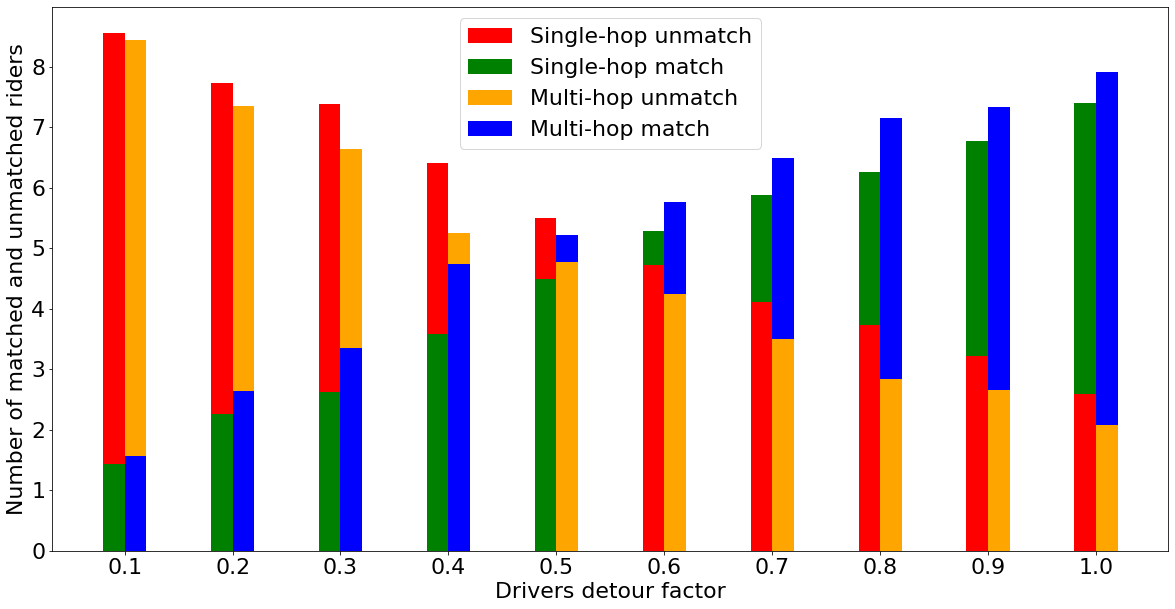

In [188]:
import pandas as pd

fig= plt.figure(figsize=(20, 10))

size = list(np.arange(10))
#plt.bar([1],3,align='edge', width= -0.4 , color='pink')

unmatch_mhop = [x for x,_ in show_res3[0][4]]
match_mhop = [x for x,_ in show_res3[0][5]]
unmatch_shop = [x for x,_ in show_res3[1][4]]
match_shop = [x for x,_ in show_res3[1][5]]

i = 0.1
for unm_s,m_s, unm_m, m_m in zip(unmatch_shop, match_shop, unmatch_mhop, match_mhop):
    if m_s<unm_s:
        plt.bar(i, unm_s, align='edge', width= -0.02 , color='red')
        plt.bar(i, m_s, align='edge', width= -0.02 , color='green')
    else:
        plt.bar(i, m_s, align='edge', width= -0.02 , color='green')
        plt.bar(i, unm_s, align='edge', width= -0.02 , color='red')
        
    if m_m<unm_m:
        plt.bar(i, unm_m, align='edge', width= 0.02 , color='orange')
        plt.bar(i, m_m, align='edge', width= 0.02 , color='blue')
    else:
        plt.bar(i, m_m, align='edge', width= 0.02 , color='blue')
        plt.bar(i, unm_m, align='edge', width= 0.02 , color='orange')
        
    i+=0.1
    
plt.xlabel('Drivers detour factor')
plt.ylabel('Number of matched and unmatched riders')
#plt.ylabel(entries[i])
plt.legend(['Single-hop unmatch','Single-hop match','Multi-hop unmatch','Multi-hop match'])
plt.xticks(np.arange(0.1, 1.1, 0.1))
#plt.legend(['2'])

path = '/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp_conf_ieee/xp2_50run/match_unmatch.png'
plt.savefig(path,format='png',dpi=400)
plt.show()

### Multiprocessing xp

In [220]:
import time
from timeit import default_timer as timer
from multiprocessing import Pool, cpu_count

def power(hop, det_d):
    print(hop,det_d,"begins")
    TIME_LIMIT = 750 #secondes

    NB_RIDERS = 5
    WT_R = 3
    RIDER_FREQUENCY = NB_RIDERS/(TIME_LIMIT-(WT_R*60)) #nombre de passagers par secondes
    #print("Frequence d'apparition passager:",RIDER_FREQUENCY,"par secondes.")
    DET_FACTOR_R = 0.2


    NB_DRIVERS = 7
    DRIVER_FREQUENCY = NB_DRIVERS/(TIME_LIMIT-(WT_R*60)) #nombre de conducteurs par secondes
    #print("Frequence d'apparition conducteurs:",DRIVER_FREQUENCY,"par secondes.")
    seed = 1
    
    NB_RUN = 1 #1 run = 30 minutes
    
        

    trip_time=[]
    start_waiting_time=[]
    total_waiting_time=[]
    trip_length=[]
    nb_unmatched=[]
    nb_matched=[]
    nb_shop=[]
    nb_mhop=[]
    saved_distance=[] 
        
    for j in range(NB_RUN):
        random.seed(seed)
        count_id = 0
        global sma
        sma = SMA(place='grid', show_graph=False, verbose=False, hop=hop)

        riders_nodes = []
        for _ in range(NB_RIDERS):
            v1, v2 = random.sample(list(sma.G.nodes),2)
            while not nx.has_path(sma.G, v1, v2):
                v1, v2 = random.sample(list(sma.G.nodes),2)
            riders_nodes.append((v1, v2))


        drivers_nodes = []
        for _ in range(NB_DRIVERS):
            v1, v2 = random.sample(list(sma.G.nodes),2)
            while not nx.has_path(sma.G, v1, v2):
                v1, v2 = random.sample(list(sma.G.nodes),2)
            drivers_nodes.append((v1,v2))
               
        
        #on ajoute 10% des utilisateurs au départ
        for _ in range(int(NB_DRIVERS/10)):
            v1, v2 = drivers_nodes.pop()
            d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
            sma.addAgent(d)
            count_id+=1
                
        for _ in range(int(NB_RIDERS/10)):
            v1, v2 = riders_nodes.pop()
            r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
            sma.addAgent(r)
            count_id+=1  
                
                
                
        drivers_frequency = 0
        riders_frequency = 0

        for _ in range(TIME_LIMIT):
            if sma.tick%int(TIME_LIMIT/4)==0:
                print(hop,det_d,"tick:",sma.tick)

            drivers_frequency+=DRIVER_FREQUENCY
            while drivers_frequency>=1 and len(drivers_nodes)>0:
                v1, v2 = drivers_nodes.pop()
                d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
                sma.addAgent(d)
                    #print("new_d")
                count_id+=1
                drivers_frequency-=1

            riders_frequency+=RIDER_FREQUENCY
            while riders_frequency>=1 and len(riders_nodes)>0:
                v1, v2 = riders_nodes.pop()
                r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
                sma.addAgent(r)
                #print("new_r")
                count_id+=1  
                riders_frequency-=1
                
            sma.runOnce()
            
        trip_time.extend(sma.data['d_trip_time'])
        total_waiting_time.extend(sma.data['r_total_waiting_time'])
        start_waiting_time.extend(sma.data['r_start_waiting_time'])
        trip_length.extend(sma.data['d_trip_length'])
        nb_unmatched.extend([sma.data['r_nb_unmatched']])
        nb_matched.extend([sma.data['r_nb_matched']])
        nb_shop.extend([sma.data['shop_count']])
        nb_mhop.extend([sma.data['mhop_count']])
        saved_distance.extend([sma.data['saved_distance']])  

        
    print(hop,det_d,"run:",j,"finished")        
    
    return [hop, det_d, trip_time, trip_length, start_waiting_time, total_waiting_time,  nb_unmatched, nb_matched, saved_distance, nb_shop, nb_mhop]


def main():
    DET_FACTOR_D = [1,0.8,0.6,0.4,0.2]
    HOP = ['mhop','shop']
    values = []
    res = None
    #DET_FACTOR_D = [0.1,0.2]
    for hop in HOP:
        for det_d in DET_FACTOR_D:
            values.append((hop,det_d))
   
    start = timer()

    print(f'starting computations on {cpu_count()} cores')

    with Pool() as pool:
        res = pool.starmap(power, values)
        print(res)

    end = timer()
    print(f'elapsed time: {end - start}')
    return res

if __name__ == '__main__':
    res = main()

starting computations on 16 cores
mhop 1 begins
mhop 0.4 begins
mhop 0.8 begins
mhop 0.2 begins
shop 1 begins
mhop 0.6 begins
shop 0.8 begins
shop 0.6 begins
shop 0.4 begins
shop 0.2 begins
mhop 0.2 tick: 0
shop 1 tick: 0
shop 0.2 tick: 0
mhop 1 tick: 0
shop 0.4 tick: 0
shop 0.8 tick: 0
shop 1 tick: 187
shop 0.2 tick: 187
mhop 0.2 tick: 187
shop 0.4 tick: 187
mhop 1 tick: 187
mhop 0.8 tick: 0
mhop 0.4 tick: 0
shop 0.8 tick: 187
mhop 0.8 tick: 187
mhop 0.4 tick: 187
shop 0.6 tick: 0
mhop 0.6 tick: 0
mhop 0.6 tick: 187
shop 0.6 tick: 187
shop 1 tick: 374
shop 0.2 tick: 374
shop 0.4 tick: 374
shop 1 tick: 561
shop 0.8 tick: 374
mhop 1 tick: 374
mhop 0.4 tick: 374
shop 0.2 tick: 561
shop 0.4 tick: 561
shop 1 tick: 748
shop 1 run: 0 finished
mhop 0.6 tick: 374
shop 0.2 tick: 748
shop 0.2 run: 0 finished
mhop 0.2 tick: 374
shop 0.6 tick: 374
mhop 0.8 tick: 374
shop 0.4 tick: 748
shop 0.4 run: 0 finished
shop 0.8 tick: 561
mhop 1 tick: 561
mhop 0.4 tick: 561
shop 0.8 tick: 748
shop 0.8 run: 0

In [89]:

# import csv
# with open('/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp_conf_ieee/xp3_ajout_drivers/data.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerows(res)
    

In [107]:
show_res = []
mean_trip_time = []
mean_trip_length = []
mean_start_waiting_time = []
mean_total_waiting_time = []
mean_nb_unmatched = []
mean_nb_matched = []
mean_saved_distance = [] 

for i in range(len(res)):
    mean_trip_time.insert(0,(np.mean(res[i][2])/60,np.std(res[i][2])/60))
    mean_trip_length.insert(0,(np.mean(res[i][3])/1000,np.std(res[i][3])/1000))
    mean_start_waiting_time.insert(0,(np.mean(res[i][4])/60,np.std(res[i][4])/60))
    mean_total_waiting_time.insert(0,(np.mean(res[i][5])/60,np.std(res[i][5])/60))
    mean_nb_unmatched.insert(0,(np.mean(res[i][6]),np.std(res[i][6]))) #meme si une seule valeur
    mean_nb_matched.insert(0,(np.mean(res[i][7]),np.std(res[i][7]))) #meme si une seule valeur
    mean_saved_distance.insert(0,(np.mean(res[i][8])/1000,np.std(res[i][8])/1000))
    if i == 4 or i == len(res)-1:
        show_res.append([mean_trip_time, mean_trip_length, mean_start_waiting_time, mean_total_waiting_time, mean_nb_unmatched, mean_nb_matched, mean_saved_distance])
        mean_trip_time = []
        mean_trip_length = []
        mean_start_waiting_time = []
        mean_total_waiting_time = []
        mean_nb_unmatched = []
        mean_nb_matched = []
        mean_saved_distance = []  
        
show_res

[[[(1.3065555555555555, 0.5975316407759467),
   (1.4302222222222223, 0.8051095776965801),
   (1.598888888888889, 0.9182928336838211),
   (1.7581111111111112, 1.0322695898711922),
   (1.8766666666666665, 1.121741371129595)],
  [(0.9270078799999998, 0.47304841238868167),
   (1.0199469733333333, 0.6497604214280619),
   (1.1646042333333335, 0.7244705461644333),
   (1.28005072, 0.8209398508551452),
   (1.3762872066666667, 0.8881335287666624)],
  [(0.7967741935483871, 0.6956395081905083),
   (0.8163333333333332, 0.7269455886714554),
   (0.8208994708994709, 0.7290215245052508),
   (0.5198312236286919, 0.6292734405130022),
   (0.5285416666666667, 0.6473192248183615)],
  [(1.7274193548387096, 0.8338229570976662),
   (1.7113333333333334, 0.9485804598919845),
   (1.9235449735449737, 0.9087058598293171),
   (1.6267932489451478, 0.8191640009722606),
   (1.7083333333333333, 0.9638896894008844)],
  [(34.5, 0.5), (25.0, 2.0), (18.5, 3.5), (10.5, 3.5), (10.0, 2.0)],
  [(15.5, 0.5), (25.0, 2.0), (31.5, 

In [104]:
show_res[1]

[[(1.3131333333333333, 0.566532432467054),
  (1.3074222222222223, 0.6180738475195777),
  (1.3479333333333334, 0.6408361054700914),
  (1.4297555555555554, 0.7239046485877222),
  (1.4636444444444445, 0.7684239133559575)],
 [(0.9428687200000001, 0.4590357179455373),
  (0.9377385013333333, 0.5003086459435102),
  (0.9646261706666667, 0.514412865838661),
  (1.0277711706666666, 0.5837872114064692),
  (1.0514970293333332, 0.6125624503133628)],
 [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)],
 [(0.923931623931624, 0.6422427192459471),
  (0.8987373737373737, 0.5379519915093357),
  (0.9518849206349207, 0.5689160118643889),
  (0.929887482419128, 0.5385544250375359),
  (0.9912515964240103, 0.6614089352368298)],
 [(8.44, 1.134195750300626),
  (7.36, 1.2289833196589772),
  (6.64, 1.5844241856270687),
  (5.26, 1.585055204085965),
  (4.78, 1.46)],
 [(1.56, 1.134195750300626),
  (2.64, 1.2289833196589772),
  (3.36, 1.5844241856270687),
  (4.74, 1.585055204085965),
  (5.22, 1.46)],
 [(1.026

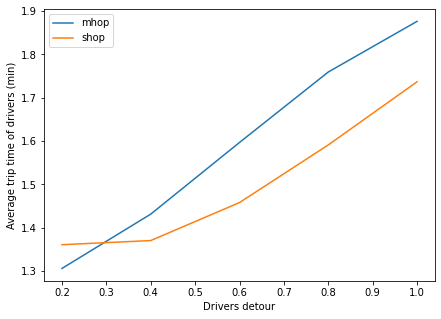

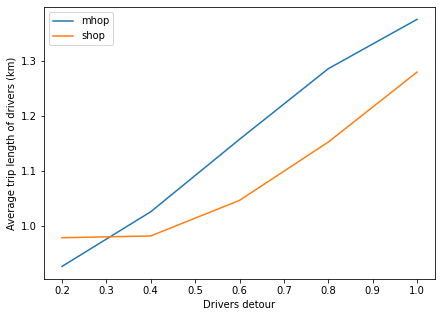

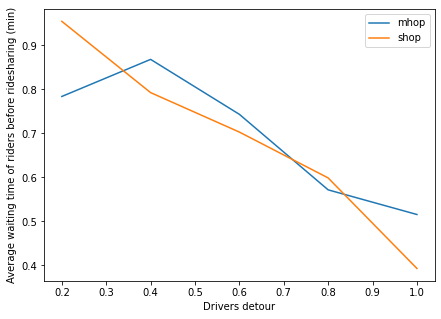

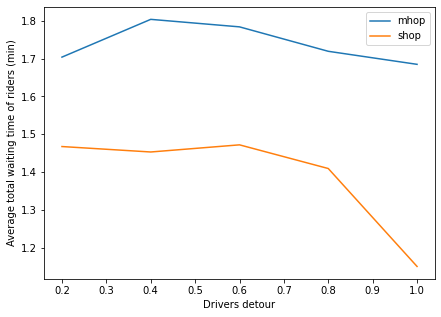

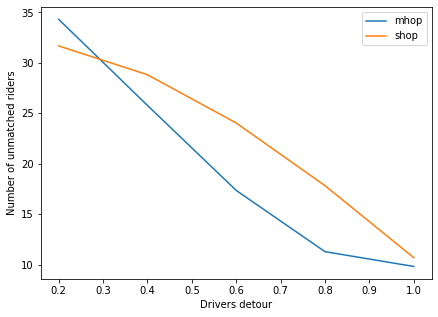

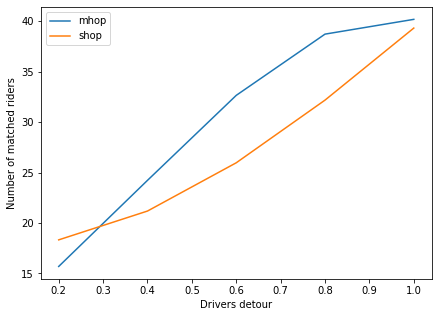

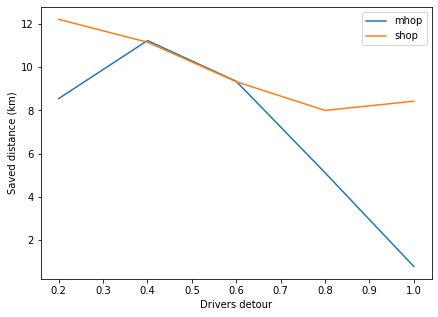

In [110]:
entries = ["Average trip time of drivers (min)","Average trip length of drivers (km)","Average waiting time of riders before ridesharing (min)", "Average total waiting time of riders (min)",
            "Number of unmatched riders","Number of matched riders", "Saved distance (km)"]
DET_FACTOR_D = [0.2,0.4,0.6,0.8,1]
HOP = ['mhop','shop']
for i in range(len(entries)) :
    f = plt.figure(figsize=(7, 5))
    for j in range(len(HOP)):
        avg = [x for x,_ in show_res[j][i]]
        poly_avg = np.polyfit(DET_FACTOR_D,avg,3) 
        poly_y_avg = np.poly1d(poly_avg)(DET_FACTOR_D)
        
        
        #std = [x for _,x in show_res[j][i]]
        #poly_std = np.polyfit(MAX_NB_DRIVERS,std,5) 
        #poly_y_std = np.poly1d(poly_std)(MAX_NB_DRIVERS)
        #plt.plot(DET_FACTOR_D, avg, label = HOP[j])
        plt.plot(DET_FACTOR_D, poly_y_avg, label = HOP[j])
        #plt.fill_between(DET_FACTOR_D, np.add(avg,std), np.subtract(avg,std), alpha=0.2)

    plt.xlabel('Drivers detour')
    plt.ylabel(entries[i])
    plt.legend()
    
    entry = entries[i].replace(' ','_').split("(")[0]
    path = '/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp_conf_ieee/xp3_ajout_drivers/'+entry+'.png'
    plt.savefig(path,format='png')
    plt.show()

In [14]:
import time
from timeit import default_timer as timer
from multiprocessing import Pool, cpu_count

def power(hop, det_d):
    print(hop,det_d,"begins")
    TIME_LIMIT = 650 #secondes

    NB_RIDERS = 75
    WT_R = 3
    RIDER_FREQUENCY = NB_RIDERS/(TIME_LIMIT-(WT_R*60)) #nombre de passagers par secondes
    #print("Frequence d'apparition passager:",RIDER_FREQUENCY,"par secondes.")
    DET_FACTOR_R = 0.5


    NB_DRIVERS = 100
    DRIVER_FREQUENCY = NB_DRIVERS/(TIME_LIMIT-(WT_R*60)) #nombre de conducteurs par secondes
    #print("Frequence d'apparition conducteurs:",DRIVER_FREQUENCY,"par secondes.")
    
    
    seed = 1

    local_mean_nb_unmatched = []
    local_mean_waiting_time = []
    local_mean_trip_length = []
    local_mean_trip_time = []
    local_mean_nb_shop = []
    local_mean_nb_mhop = []
    local_mean_saved_distance = []
        
    
    random.seed(seed)
    count_id = 0
    global sma
    sma = SMA(place='grid', show_graph=False, verbose=False, hop=hop)

    riders_nodes = []
    for _ in range(NB_RIDERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)
        riders_nodes.append((v1, v2))


    drivers_nodes = []
    for _ in range(NB_DRIVERS):
        v1, v2 = random.sample(list(sma.G.nodes),2)
        while not nx.has_path(sma.G, v1, v2):
            v1, v2 = random.sample(list(sma.G.nodes),2)
        drivers_nodes.append((v1,v2))
               
        
        #on ajoute 10% des utilisateurs au départ
    for _ in range(int(NB_DRIVERS/10)):
        v1, v2 = drivers_nodes.pop()
        d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
        sma.addAgent(d)
        count_id+=1
                
    for _ in range(int(NB_RIDERS/10)):
        v1, v2 = riders_nodes.pop()
        r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
        sma.addAgent(r)
        count_id+=1  
                
                
                
    drivers_frequency = 0
    riders_frequency = 0

    for _ in range(TIME_LIMIT):
        if sma.tick%int(TIME_LIMIT/4)==0:
            print(hop,det_d,"tick:",sma.tick)

        drivers_frequency+=DRIVER_FREQUENCY
        while drivers_frequency>=1 and len(drivers_nodes)>0:
            v1, v2 = drivers_nodes.pop()
            d = ContinuousDriverAgent(count_id, v1, v2, detour_factor=det_d, pref_weight='travel_time',test=False)
            sma.addAgent(d)
                    #print("new_d")
            count_id+=1
            drivers_frequency-=1

        riders_frequency+=RIDER_FREQUENCY
        while riders_frequency>=1 and len(riders_nodes)>0:
            v1, v2 = riders_nodes.pop()
            r = RiderAgent(count_id, v1, v2, detour_factor=DET_FACTOR_R, waiting_time=WT_R, pref_weight='travel_time')
            sma.addAgent(r)
            #print("new_r")
            count_id+=1  
            riders_frequency-=1
                
        sma.runOnce()
            
        #on récupère les données
    trip_time=sma.data['d_trip_time']
    waiting_time=sma.data['r_waiting_time']
    trip_length=sma.data['d_trip_length']
    nb_unmatched=sma.data['r_nb_unmatched']
    nb_shop=sma.data['shop_count']
    nb_mhop=sma.data['mhop_count']
    saved_distance=sma.data['saved_distance']
        

        
    print(hop,det_d,"finished")        
    
    return [hop, det_d, trip_time, waiting_time, trip_length, nb_unmatched, saved_distance, nb_shop, nb_mhop]


def main():
    DET_FACTOR_D = [1,0.8,0.6,0.4,0.2]
    HOP = ['mhop','shop']
    values = []
    res = None
    #DET_FACTOR_D = [0.1,0.2]
    for hop in HOP:
        for det_d in DET_FACTOR_D:
            values.append((hop,det_d))
   
    start = timer()

    print(f'starting computations on {cpu_count()} cores')

    with Pool() as pool:
        res = pool.starmap(power, values)
        print(res)

    end = timer()
    print(f'elapsed time: {end - start}')
    return res3

if __name__ == '__main__':
    res3 = main()

starting computations on 16 cores
mhop 0.6 begins
mhop 0.8 begins
mhop 1 begins
mhop 0.4 begins
shop 1 begins
shop 0.8 begins
mhop 0.2 begins
shop 0.6 begins
shop 0.4 begins
shop 0.2 begins
shop 0.2 tick: 0
shop 1 tick: 0
mhop 1 tick: 0
shop 0.4 tick: 0
mhop 0.2 tick: 0
shop 0.6 tick: 0
mhop 0.6 tick: 0
shop 0.8 tick: 0
mhop 0.8 tick: 0
mhop 0.4 tick: 0
shop 1 tick: 162
shop 0.6 tick: 162
shop 0.8 tick: 162
mhop 1 tick: 162
mhop 0.8 tick: 162
shop 0.4 tick: 162
shop 1 tick: 324
shop 0.2 tick: 162
mhop 0.6 tick: 162
shop 0.8 tick: 324
shop 0.6 tick: 324
mhop 0.4 tick: 162
shop 1 tick: 486
shop 1 tick: 648
shop 1 finished
mhop 1 tick: 324
shop 0.8 tick: 486
shop 0.8 tick: 648
shop 0.8 finished
shop 0.6 tick: 486
shop 0.6 tick: 648
shop 0.6 finished
mhop 0.8 tick: 324
shop 0.4 tick: 324
mhop 1 tick: 486
mhop 1 tick: 648
mhop 1 finished
shop 0.2 tick: 324
mhop 0.2 tick: 162
shop 0.4 tick: 486
shop 0.4 tick: 648
shop 0.4 finished
mhop 0.6 tick: 324
mhop 0.8 tick: 486
mhop 0.8 tick: 648
mhop

In [60]:
res
res2=res

In [19]:
# import csv
# with open('results_big_xp_1seed.csv', 'w', newline='') as file:
#     mywriter = csv.writer(file, delimiter=',')
#     mywriter.writerows(res2)

In [51]:
show_res = []
mean_trip_time = []
mean_waiting_time = []
mean_trip_length = []
mean_nb_unmatched = []
mean_saved_distance = [] 

for i in range(len(res2)):
    mean_trip_time.insert(0,(np.mean(res2[i][2])/60,np.std(res2[i][2])/60))
    mean_waiting_time.insert(0,(np.mean(res2[i][3])/60,np.std(res2[i][3])/60))
    mean_trip_length.insert(0,(np.mean(res2[i][4])/1000,np.std(res2[i][4])/1000))
    mean_nb_unmatched.insert(0,(np.mean(res2[i][5]),np.std(res2[i][5]))) #meme si une seule valeur
    mean_saved_distance.insert(0,(np.mean(res2[i][6])/1000,np.std(res2[i][6])/1000))
    if i == 4 or i == 9:
        show_res.append([mean_trip_time, mean_waiting_time, mean_trip_length, mean_nb_unmatched, mean_saved_distance])
        mean_trip_time = []
        mean_waiting_time = []
        mean_trip_length = []
        mean_nb_unmatched = []
        mean_saved_distance = [] 
        
show_res
        
        
    
    
# mean_trip_time=((np.mean(local_mean_trip_time),np.std(local_mean_trip_time)))
# mean_waiting_time=((np.mean(local_mean_waiting_time),np.std(local_mean_waiting_time)))
# mean_trip_length=((np.mean(local_mean_trip_length),np.std(local_mean_trip_length)))
# mean_nb_unmatched=((np.mean(local_mean_nb_unmatched),np.std(local_mean_nb_unmatched)))
# mean_nb_shop=((np.mean(local_mean_nb_shop),np.std(local_mean_nb_shop)))
# mean_nb_mhop=((np.mean(local_mean_nb_mhop),np.std(local_mean_nb_mhop)))
# mean_saved_distance=((np.mean(local_mean_saved_distance),np.std(local_mean_saved_distance)))    
#[mean_trip_time, mean_waiting_time, mean_trip_length, mean_nb_unmatched, mean_saved_distance, mean_nb_shop, mean_nb_mhop])

[[[(1.4236666666666666, 0.6591668984407515),
   (1.588, 0.8431754792976898),
   (1.7133333333333334, 0.9799574820708634),
   (1.943, 1.1423250656251729),
   (2.163299663299663, 1.2659110359067156)],
  [(1.5371212121212123, 0.8550788819743654),
   (1.775, 1.0582520903700057),
   (1.4453900709219858, 0.7916131159765147),
   (1.5920765027322403, 0.7678928573787296),
   (1.3715686274509804, 0.6555012228313615)],
  [(1.0242251499999997, 0.5280332050527764),
   (1.1497170199999998, 0.6741921188256947),
   (1.2435438099999998, 0.7775000056646134),
   (1.4203971999999996, 0.9062258064965265),
   (1.5947941414141418, 1.0128146512005767)],
  [(53.0, 0.0), (33.0, 0.0), (28.0, 0.0), (14.0, 0.0), (7.0, 0.0)],
  [(17.541626000000008, 0.0),
   (22.557441000000008, 0.0),
   (18.253521000000006, 0.0),
   (17.286314000000004, 0.0),
   (7.38731799999999, 0.0)]],
 [[(1.4115, 0.6426451197978554),
   (1.4978333333333333, 0.7677262786233704),
   (1.6438333333333333, 0.9333471873971777),
   (1.777833333333333

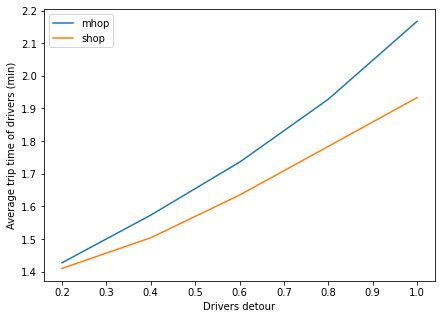

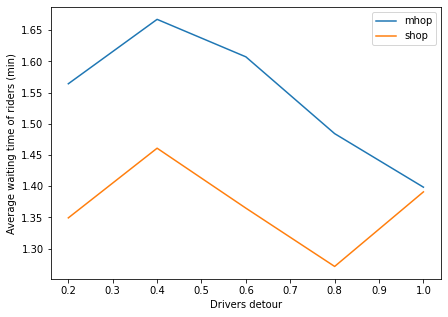

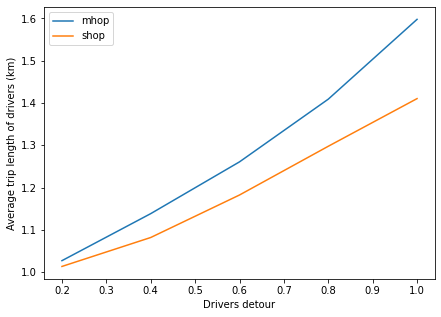

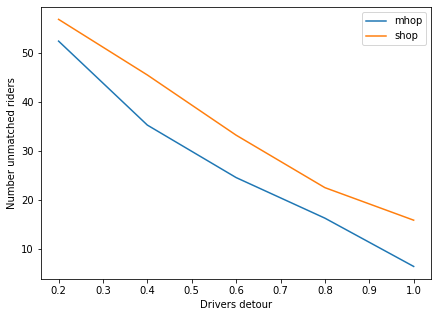

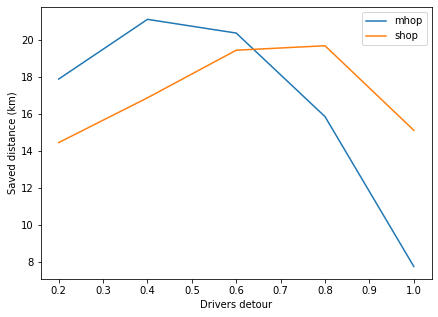

In [59]:
entries = ["Average trip time of drivers (min)", "Average waiting time of riders (min)", 
           "Average trip length of drivers (km)", "Number unmatched riders", "Saved distance (km)"]
DET_FACTOR_D = [0.2,0.4,0.6,0.8,1]
HOP = ['mhop','shop']
for i in range(len(entries)) :
    f = plt.figure(figsize=(7, 5))
    for j in range(len(HOP)):
        avg = [x for x,_ in show_res[j][i]]
        poly_avg = np.polyfit(DET_FACTOR_D,avg,3) 
        poly_y_avg = np.poly1d(poly_avg)(DET_FACTOR_D)
        
        
        #std = [x for _,x in show_res[j][i]]
#         poly_std = np.polyfit(MAX_NB_DRIVERS,std,5) 
#         poly_y_std = np.poly1d(poly_std)(MAX_NB_DRIVERS)
        #plt.plot(DET_FACTOR_D, avg, label = HOP[j])
        plt.plot(DET_FACTOR_D, poly_y_avg, label = HOP[j])
        #plt.fill_between(DET_FACTOR_D, np.add(avg,std), np.subtract(avg,std), alpha=0.2)

    plt.xlabel('Drivers detour')
    plt.ylabel(entries[i])
    plt.legend()
    
    #entry = entries[i].replace(' ','_').split("(")[0]
    #path = '/home/fevrec/Documents/These/these/smac_agents/mas_basics/xp1/'+entry+'.png'
    #plt.savefig(path,format='png')
    plt.show()

In [ ]:
d_id = 49
print("arr",sma.getAgentFromId(d_id).arr)
print("ddl",sma.getAgentFromId(d_id).ddl)
print("slk",sma.getAgentFromId(d_id).slk)
print("cap",sma.getAgentFromId(d_id).capacities)
print("perc",sma.getAgentFromId(d_id).perceptions)
print("stops",sma.getAgentFromId(d_id).stops)
print("trip",sma.getAgentFromId(d_id).trip)
print("v_r",sma.getAgentFromId(d_id).current_pos)
print("v_arr",sma.getAgentFromId(d_id).v_arr)
sma.getAgentFromId(d_id)

In [ ]:
sma.getAgentFromId(d_id).decide()

In [ ]:
d_id = 20
print("arr",sma.getAgentFromId(d_id).arr)
print("ddl",sma.getAgentFromId(d_id).ddl)
print("slk",sma.getAgentFromId(d_id).slk)
print("cap",sma.getAgentFromId(d_id).capacities)
print("perc",sma.getAgentFromId(d_id).perceptions)
print("stops",sma.getAgentFromId(d_id).stops)
print("trip",sma.getAgentFromId(d_id).trip)
print("v_r",sma.getAgentFromId(d_id).current_pos)
print("v_arr",sma.getAgentFromId(d_id).v_arr)
sma.getAgentFromId(d_id)

In [ ]:
nx.has_path(G,53090940,53027459)

In [ ]:
class SMA:
    def __init__(self, verbose=False, place='Piedmont, California, USA', speed=50, show_graph=False, hop='mhop'):
        self.tick=0 #1 tick = 1 seconde
        self.resetTicks()
        
        if hop in ['mhop','shop','nohop']:
            self.hop = hop
        else :
            raise Exception("hop parameters is either : mhop, shop or nohop")
            
        
        if place=='grid':
            north, south, east, west = 37.79, 37.78, -122.41, -122.43
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
            
            
        else:
            gdf = ox.geocode_to_gdf(place) 
            # get the street network within this bounding box
            west, south, east, north = list(gdf.bounds.iloc[0])
            self.min_lat, self.min_lon, self.max_lat, self.max_lon = south, west, north ,east 
            #self.bbox = (self.min_lon, self.min_lat, self.max_lon, self.max_lat)
            
        self.G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
        
#         #filter deadends
#         deadends = []
#         for node in list(self.G.nodes):
#             if self.G.nodes[node]['street_count']==1:
#                 deadends.append(node)
#         print(deadends)
#         self.G.remove_nodes_from(deadends)
        
        if show_graph:
            fig, ax = ox.plot_graph(self.G, figsize=(20, 20),  node_size=20)
        self.speed = speed
        # hwy_speeds = {'residential': 30,
        #               'secondary': 50,
        #               'tertiary': 70}

        hwy_speeds = {'residential': self.speed,
                      'primary':self.speed,
                      'secondary': self.speed,
                      'tertiary': self.speed,
                      'motorway': self.speed,
                      'trunk': self.speed}

        self.G = ox.add_edge_speeds(self.G, hwy_speeds, precision=0)
        #temps arrondis
        self.G = ox.add_edge_travel_times(self.G, precision=0)
        
        #dictionnaire des agents par type
        self.agentTypeIdDict = {}
        self.agentTypeIdDict["drivers"] = []
        self.agentTypeIdDict["riders"] = []
        self.agentTypeIdDict["tsas"] = []
        self.agentTypeIdDict["tgas"] = []
        
        #dictionnaire des agents par id
        self.agentDict = {}
        
        #arbre d'indexation spatiale R-TREE
        self.rtree = rtree.index.Index()
        
        #self.G = None
        self.verbose = verbose
        
        
        ####DATA####
        self.data = dict()
        self.data['d_trip_time'] = []
        self.data['d_trip_length'] = []
        self.data['r_waiting_time'] = []
        self.data['r_nb_unmatched'] = 0
    
    def resetTicks(self):
        self.tick=0
          
    def setRoadGraph(self,graph):
        self.G = graph
        
    def addAgent(self,ag):
        self.agentDict[ag.unique_id] = ag
        if "RiderAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["riders"].append(ag.unique_id)
        elif "DriverAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["drivers"].append(ag.unique_id)
        elif "TransportServiceAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tsas"].append(ag.unique_id)
        elif "TransportGeneratorAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tgas"].append(ag.unique_id)
        else: raise Exception(ag.__class__.__name__,"is a wrong type of agent.")
            
            
    def getAgentFromId(self, unique_id):
        return self.agentDict[unique_id]
    
    def getRiders(self):
        R = []
        for r in self.agentTypeIdDict['riders']:
            R.append(self.agentDict[r])
        return R
        
    def getDrivers(self):
        D = []
        for d in self.agentTypeIdDict['drivers']:
            D.append(self.agentDict[d])
        return D
        
    def getTSAs(self):
        TSA = []
        for tsa in self.agentTypeIdDict['tsas']:
            TSA.append(self.agentDict[tsa])
        return TSA
    
    def getTGAs(self):
        TGA = []
        for tga in self.agentTypeIdDict['tgas']:
            TGA.append(self.agentDict[tga])
        return TGA

    def run(self,rounds=None):
        if rounds==None:
            #on s'arrete si tout les passagers ou tout les conducteurs sont arrivés
            self.runOnce()
            while len([agent for agent in sma.agentDict.values() if ("RiderAgent" in agent.__class__.__name__)]) > 0 and len([agent for agent in sma.agentDict.values() if ("DriverAgent" in agent.__class__.__name__)]) > 0:
                self.runOnce()
            #print("Finished in",self.tick,"ticks")
        
        else :
            #génération classique
            for i in range(0,rounds):
                self.runOnce()

    def runOnce(self):
        self.tick+=1
        #random.shuffle(self.agentList)
        for ag in self.agentDict.values() :
            #print(ag.unique_id)
            ag.update()
            ag.decide()
        
        #phase de nettoyage des agents morts
        for ag in self.agentDict.copy().values():
            if ag.is_alive == False:
                if "RiderAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["riders"].remove(ag.unique_id)
                elif "DriverAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["drivers"].remove(ag.unique_id)
                elif "TransportServiceAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tsas"].remove(ag.unique_id)
                elif "TransportGeneratorAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tgas"].remove(ag.unique_id)
                else: raise Exception(ag.__class__.__name__,"is a wrong type of agent, even if diying.")
                
                self.agentDict.pop(ag.unique_id)
                
                
        if self.verbose == True:      
            print("tick",str(self.tick),"ended")

In [ ]:
a = ['mhop','shop','nohop']
'mhop' in a

In [ ]:
#remplacé par r-tree
class TransportServiceAgent(Agent):
    #tsa : agent blackboard
    def __init__(self, unique_id):
        super().__init__(unique_id)
        self.nodes_to_drivers = dict()
        for node in list(sma.G.nodes):
            self.nodes_to_drivers[node] = set()
        self.drivers_to_nodes = dict()
        
    
     
    def update_driver_data(self, d):
        if d.is_alive == False:
            for node in self.drivers_to_nodes[d]:
                self.nodes_to_drivers[node].remove(d)
            del self.drivers_to_nodes[d]
            
        else :
            node_set = set([item for sublist in d.perceptions for item in sublist])
            #print("node set",node_set)
            #print("d nodes ranges",d.perceptions)
            if d in self.drivers_to_nodes.keys() :
                #noeuds à retirer
                old_nodes = self.drivers_to_nodes[d] - node_set
                #noeuds à ajouter
                new_nodes = node_set - self.drivers_to_nodes[d]

                for old_node in old_nodes:
                    self.nodes_to_drivers[old_node].remove(d)

                for new_node in new_nodes:
                    self.nodes_to_drivers[new_node].add(d)
            else :
                for node in node_set:
                    self.nodes_to_drivers[node].add(d)


            self.drivers_to_nodes[d] = node_set
            
    def get_drivers_from_node(self, node):
        
        return self.nodes_to_drivers[node]
    
    def get_nodes_from_driver(self,driver):
        
        return self.drivers_to_nodes[driver]
    
    def update(self):
        #print("nodes to drivers",self.nodes_to_drivers)
        #print("drivers to nodes",self.drivers_to_nodes)
        pass
    
    def decide(self):
        pass

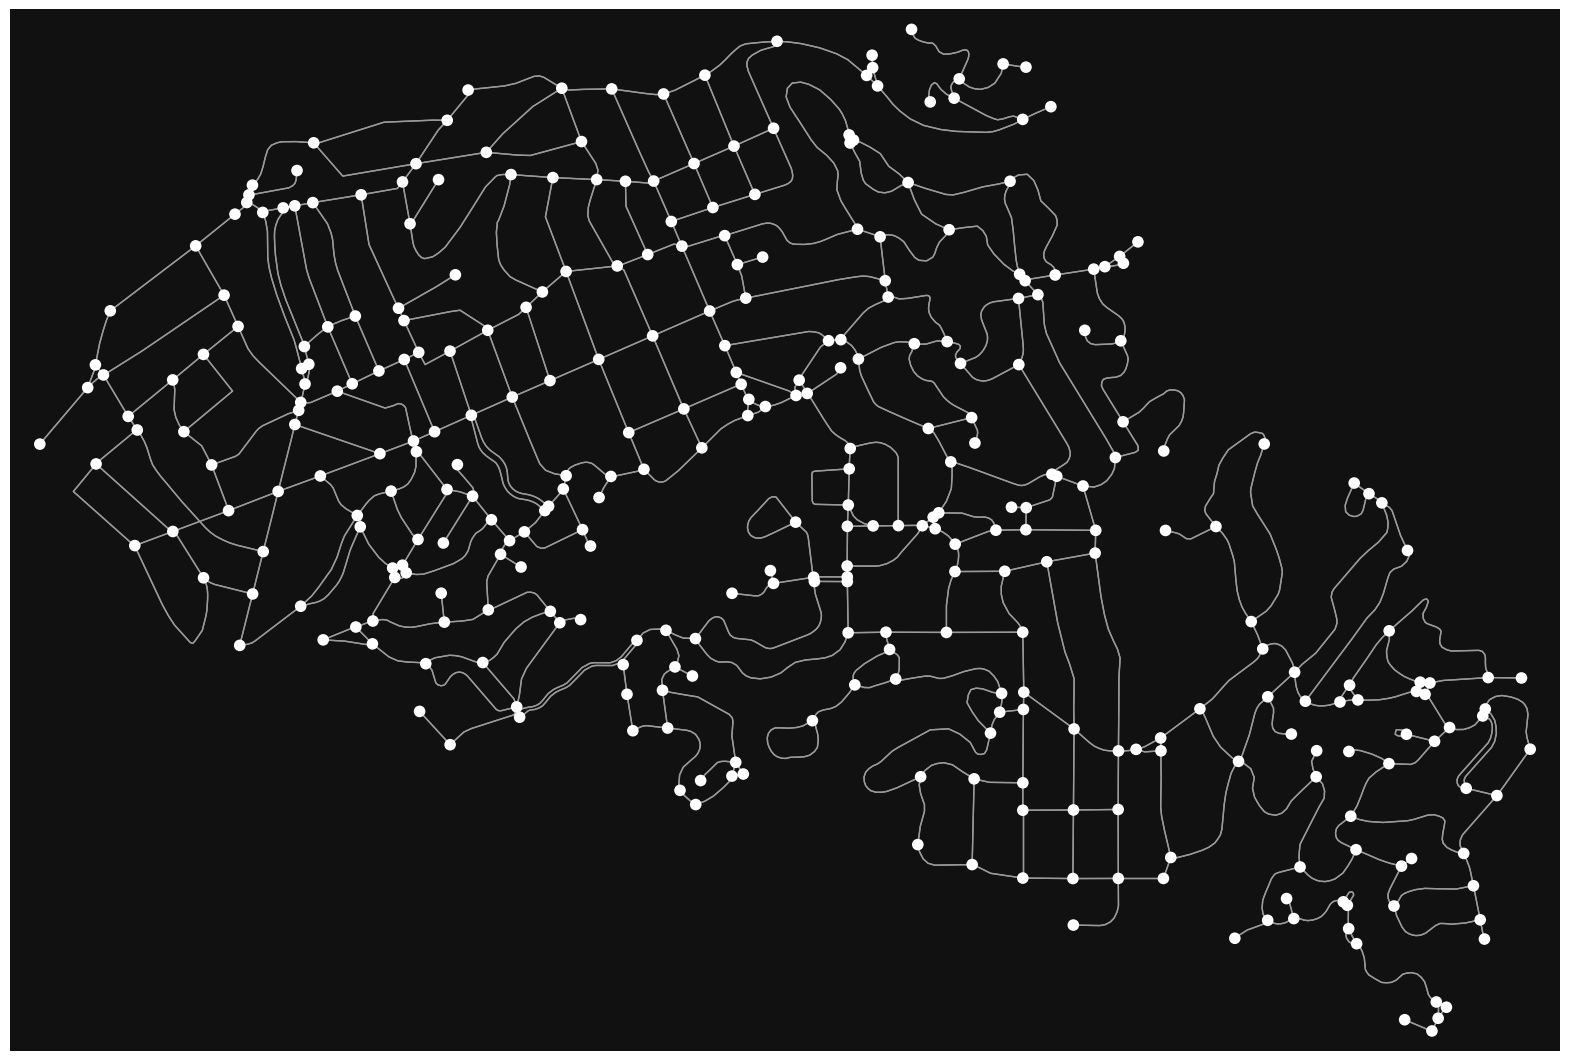

In [208]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive') 
fig, ax = ox.plot_graph(G,  figsize=(20, 20),  node_size=70)
hwy_speeds = {'residential': 30,
              'secondary': 50,
              'tertiary': 70}
G = ox.add_edge_speeds(G, hwy_speeds)

#temps arrondis
G = ox.add_edge_travel_times(G, precision=0)

    

In [212]:
d = dict(nx.all_pairs_dijkstra(G, weight="travel_time"))

In [218]:
d[53017091][0][53018411]

23.0

In [ ]:
def get_SP(sp_dict, orig, dest):
    return d[orig][1][dest]

def get_SP_time(sp_dict, orig, dest):
    return d[orig][0][dest]

In [ ]:
rounds = 10000
sma = SMA()
G = sma.G
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.5, pref_weight='travel_time',test=False)
sma.addAgent(d1)
for _ in range(rounds):
    sma.runOnce()
    #print(sma.rtree)

In [ ]:
rounds = 50
sma = SMA()
sma.setRoadGraph(G)
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
tsa1 = TransportServiceAgent(1)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.1, pref_weight='travel_time',test=True)

sma.addAgent(tsa1)
sma.addAgent(d1)

sma.runOnce()
nc = ['b' if (v in d1.get_perception_set_node()) else 'w' for v in sma.G.nodes()]

fig, ax = ox.plot_graph(sma.G, figsize=(20, 20), node_color=nc, node_edgecolor='k', node_size=70, 
                           node_zorder=3, edge_color='w', edge_linewidth=1)

In [ ]:
rounds = 50
sma = SMA()
sma.setRoadGraph(G)
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
tsa1 = TransportServiceAgent(1)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.8, pref_weight='travel_time',test=True)

sma.addAgent(tsa1)
sma.addAgent(d1)

nc = ['b' if (v in d1.get_perception_set_node()) else 'w' for v in sma.G.nodes()]

fig, ax = ox.plot_graph(sma.G, figsize=(20, 20), node_color=nc, node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color='w', edge_linewidth=3)

for _ in range(rounds):
    sma.runOnce()
print(d1.get_perception_set_node())
r1, r2 = random.sample(d1.get_perception_set_node(),2)

d1.add_rider_to_scheduler(None,  r1, r2, 60, 100)

for _ in range(10000):
    sma.runOnce()

In [ ]:
# SPL = nx.shortest_path_length(sma.G, orig, dest, weight='length')
# sub_g_orig = ox.truncate.truncate_graph_dist(sma.G, orig, max_dist=SPL/4, weight='length', retain_all=True)
# #fig, ax = ox.plot_graph(sub_g)

# sub_g_dest = ox.truncate.truncate_graph_dist(sma.G, dest, max_dist=SPL/4, weight='length', retain_all=True)
# #fig, ax = ox.plot_graph(sub_g)

# ec = ['b' if ((u,v) in sub_g_orig.edges() or (u,v) in sub_g_dest.edges()) else 'r' for u, v, k in sma.G.edges(keys=True)]

# fig, ax = ox.plot_graph(sma.G, node_color='w', node_edgecolor='k', node_size=30, 
#                            node_zorder=3, edge_color=ec, edge_linewidth=3)

In [ ]:

orig = list(G)[1]
dest = list(G)[120]
weight='travel_time'
SPL = nx.shortest_path_length(sma.G, orig, dest, weight=weight)
coef_det = 0.2
det = SPL + (SPL*coef_det)


def get_perception(self, orig, dest, max_weight):
    visited = []
    perception = []
    current_node = orig
    self.algo_recu(current_node)
    return perception

def algo_recu(self, current_node):
    for succ in G.neighbors(current_node):
        if succ not in visited :
            visited.append(succ)
            try: 
                if nx.shortest_path_length(sma.G, orig, succ, weight=self.pref_weight) + nx.shortest_path_length(sma.G, succ, dest, weight=pref_weight) <= max_weight:
                    perception.append(succ)
                    self.algo_recu(succ)
            except (KeyError, nx.NetworkXNoPath):
                pass
            
        


In [ ]:
nc = ['b' if (v in perception) else 'w' for v in sma.G.nodes()]

fig, ax = ox.plot_graph(sma.G, node_color=nc, node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color='w', edge_linewidth=3)

In [ ]:
routes = ox.k_shortest_paths(G, orig, dest, k=2, weight='length')
fig, ax = ox.plot_graph_routes(G, list(routes), route_colors='y', route_linewidth=4, node_size=0)


In [ ]:
'''Faire ce quil y a au dessus mais pour chaque noeuds composant le shortest trip ? AVEC SLK''' 

In [ ]:
def my_all_paths(G, source, target, weight_name, w):
    cutoff = len(G)-1
    visited = [source]
    stack = [iter(G[source])]
    weight = 0
    while stack:
        children = stack[-1]
        child = next(children, None)
        if child is None:
            stack.pop()
            visited.pop()
        elif len(visited) < cutoff:
            if child == target:
                if (visited[-1],child) in G.edges():
                    temp = G[visited[-1]][child][0][weight_name]
                else:
                    temp = G[child][visited[-1]][0][weight_name]
                if weight+temp <= w:
                    yield visited + [target]
            elif child not in visited:
                if (visited[-1],child) in G.edges():
                    weight += G[visited[-1]][child][0][weight_name]
                else:
                    weight += G[child][visited[-1]][0][weight_name]
                visited.append(child)
                stack.append(iter(G[child]))
        else: 
            if child == target or target in children:
                if (visited[-1],child) in G.edges():
                    temp = G[visited[-1]][child][0][weight_name]
                else:
                    temp = G[child][visited[-1]][0][weight_name]
                if weight+temp <= w:
                    yield visited + [target]
            stack.pop()
            visited.pop()

In [ ]:
def get_perception(G, source, target, weight_name, w):
    SPL = nx.shortest_path_length(G, source, target,  weight='length'))

In [ ]:
SP =  nx.shortest_path_length(sma.G, orig, dest, weight='length')
paths = list(nx.all_simple_paths(sma.G, orig, dest, cutoff=10))
#paths = list(my_all_paths(sma.G, source=orig, target=dest, weight_name='length', w=10))
        #return set([item for sublist in paths for item in sublist])

In [ ]:
a = nx.johnson(sma.G, weight='length')
a[0]

In [ ]:
len(G.nodes())

In [ ]:
sma.addAgent(d1)
for _ in range(rounds):
    sma.runOnce()